In [1]:
%load_ext autoreload
%autoreload 2

# Setup

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import h2o

from datetime import datetime

from utils import get_data, Config, clean_url, make_clickable, add_columns

from tree import make_tree

In [3]:
# Load all data (except unknown/manual testing)
# Parsing + Basic 5x+ each, and reruns (such that all tests have 5+ results)
# Ubuntu 22.04, Android 11, MacOS 14.3.1, iPadOS 17.3.1
# All runs performed between 2024-03-04 and 2024-03-22
initial_data = """
SELECT "Result".*, 
"Response".raw_header, "Response".status_code, "Response".label, "Response".resp_type,
"Browser".name, "Browser".version, "Browser".headless_mode, "Browser".os, "Browser".automation_mode, "Browser".add_info
FROM "Result"
JOIN "Response" ON "Result".response_id = "Response".id JOIN "Browser" ON "Result".browser_id = "Browser".id
WHERE "Browser".name != 'Unknown';
"""
df = get_data(Config(), initial_data)
df = add_columns(df)

Connecting to the PostgreSQL database...
Connection successful


In [4]:
df["raw_header"] = df["raw_header"].apply(bytes).apply(lambda x: json.loads(x.decode("utf-8"))).astype(str)
def create_test_id(row):
    return f'{row["test_name"]}_{row["relation_info"]}_{row["org_scheme"]}_{row["org_host"]}_{row["resp_scheme"]}_{row["resp_host"]}_{row["response_id"]}_{row["resp_type"]}'

df["browser_id"] = df["browser_id"].astype("category")
# Takes a while (1000s+) (might be faster to already do it with postgres but not too important)
df["test_id"] = df.apply(create_test_id, axis=1)
df["test_id"] = df["test_id"].astype("category")

In [5]:
responses = """
SELECT * from "Response";
"""
responses = get_data(Config(), responses)

Connecting to the PostgreSQL database...
Connection successful


# Overview
- Collected between 896150 and 1100816 results for 14 browsers

In [6]:
# Only main and finished browsers
# Remove other browsers/os
df = df.loc[~df["browser_id"].isin([30, 27, 26, 54, 28, 66])]

In [279]:
# Do not analyze OAC as it is only supported in Chromium + noisy 
df = df.loc[~df["test_name"].str.startswith("oac")]

In [ ]:
# Both basic + parsing mode
# Each test should have results 5+ times (such that we can better reason about noise + majority voting makes sense)
df.groupby(["automation_mode", "browser_id", "name", "version", "os", "headless_mode"], observed=True)["id"].count().sort_values(ascending=False).to_frame().reset_index()

## Error + Timeout Analysis
- Small number of random timeouts in both parsing/basic mode
- Very small number of not-run in Opera and Brave Android and MacOS Safari (all HSTS)
- Iterativily designed (we had more issues in the past):
  - We use higher timeouts for certain tests that timed out more often in debug runs
  - We use higher timeouts for Android
  - We use higher timeouts for the repeat runs

In [135]:
# Timeout (2), Fail (1), Not-run (3)
filtered_df = df.groupby(["browser"])["test_status"].filter(lambda x: x.nunique() >= 2)
display(df[["browser", "test_status"]].loc[df.index.isin(filtered_df.index)].groupby(["browser"])["test_status"].value_counts().to_frame().unstack().T)

browser            brave Android 11 1.62.165 intent real  \
      test_status                                          
count 0                                        1100811.0   
      2                                              NaN   
      3                                              5.0   

browser            brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new  \
      test_status                                                                        
count 0                                                     896222.0                     
      2                                                          8.0                     
      3                                                          NaN                     

browser            chrome Android 11 121.0.6167.180 intent real  \
      test_status                                                 
count 0                                                922650.0   
      2                                                     1.0   
      3                                                     NaN   

browser            chrome Ubuntu 22.04 122 selenium headless-new  \
      test_status                                                  
count 0                                                 896601.0   
      2                                                     17.0   
      3                                                      NaN   

browser            chrome iPadOS 17.3.1 122.0.6261.89 intent real  \
      test_status                                                   
count 0                                                  902103.0   
      2                                                       1.0   
      3                                                       NaN   

browser            edge Ubuntu 22.04 121 selenium headless-new  \
      test_status                                                
count 0                                               896151.0   
      2                                                    1.0   
      3                                                    NaN   

browser            firefox Ubuntu 22.04 121 selenium headless  \
      test_status                                               
count 0                                              896165.0   
      2                                                   1.0   
      3                                                   NaN   

browser            firefox Ubuntu 22.04 123 selenium headless  \
      test_status                                               
count 0                                              896165.0   
      2                                                   1.0   
      3                                                   NaN   

browser            firefox_beta Android 11 123.0b9 intent real  \
      test_status                                                
count 0                                              1015711.0   
      2                                                  191.0   
      3                                                    NaN   

browser            opera Android 11 80.5.4244.78163 intent real  \
      test_status                                                 
count 0                                                907635.0   
      2                                                    31.0   
      3                                                     8.0   

browser            safari macOS 14.3.1 17.3.1 selenium real  
      test_status                                            
count 0                                            918781.0  
      2                                                31.0  
      3                                                28.0

In [9]:
# Teststatus == 2 (timeout)

# Rare timeouts in some browsers
display(df[df["test_status"] == 2]["browser"].value_counts().to_frame())

with pd.option_context("display.max_rows", 80):
    display(df.loc[(df["test_status"] == 2)].groupby(["resp_type", "status_code", "test_name"])["browser"].value_counts().to_frame().sort_values(by="count", ascending=False))

,count
browser,
firefox_beta Android 11 123.0b9 intent real,191
opera Android 11 80.5.4244.78163 intent real,31
safari macOS 14.3.1 17.3.1 selenium real,31
chrome Ubuntu 22.04 122 selenium headless-new,17
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,8
chrome Android 11 121.0.6167.180 intent real,1
chrome iPadOS 17.3.1 122.0.6261.89 intent real,1
firefox Ubuntu 22.04 121 selenium headless,1
edge Ubuntu 22.04 121 selenium headless-new,1


count
resp_type status_code test_name               browser                                                  
basic     200         oac_iframe              firefox_beta Android 11 123.0b9 intent real            96
                      referrer_iframe         firefox_beta Android 11 123.0b9 intent real            42
          302         oac_iframe              firefox_beta Android 11 123.0b9 intent real            28
parsing   200         framing_iframe          safari macOS 14.3.1 17.3.1 selenium real               20
basic     200         fullscreen_iframe       opera Android 11 80.5.4244.78163 intent real           15
parsing   200         accesswindow_direct     firefox_beta Android 11 123.0b9 intent real            14
                      fullscreen_iframe       opera Android 11 80.5.4244.78163 intent real            9
basic     200         referrer_iframe         brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...      6
parsing   200         upgradeHSTS_subdomain   safari macOS 14.3.1 17.3.1 selenium real                6
                      framing_iframe          firefox_beta Android 11 123.0b9 intent real             5
basic     200         fullscreen_iframe       chrome Ubuntu 22.04 122 selenium headless-new           5
                      framing_embed           chrome Ubuntu 22.04 122 selenium headless-new           4
                      framing_object          chrome Ubuntu 22.04 122 selenium headless-new           4
parsing   200         upgradeHSTS_direct      safari macOS 14.3.1 17.3.1 selenium real                4
basic     302         referrer_iframe         firefox_beta Android 11 123.0b9 intent real             4
parsing   200         script_execution_iframe opera Android 11 80.5.4244.78163 intent real            4
basic     200         framing_iframe          chrome Ubuntu 22.04 122 selenium headless-new           3
                      fullscreen_iframe       brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...      2
          302         oac_window.open         firefox_beta Android 11 123.0b9 intent real             2
          200         referrer_iframe         chrome Ubuntu 22.04 122 selenium headless-new           1
                                              firefox Ubuntu 22.04 121 selenium headless              1
          302         framing_embed           chrome Android 11 121.0.6167.180 intent real            1
          200         referrer_iframe         firefox Ubuntu 22.04 123 selenium headless              1
parsing   200         accesswindow_direct     safari macOS 14.3.1 17.3.1 selenium real                1
                      fullscreen_iframe       edge Ubuntu 22.04 121 selenium headless-new             1
                      upgradeHSTS_subdomain   chrome iPadOS 17.3.1 122.0.6261.89 intent real          1
          201         script_execution_iframe opera Android 11 80.5.4244.78163 intent real            1
          203         script_execution_iframe opera Android 11 80.5.4244.78163 intent real            1
          204         script_execution_iframe opera Android 11 80.5.4244.78163 intent real            1

In [10]:
# Teststatus == 3 (not-run)

display(df[df["test_status"] == 3]["browser"].value_counts().to_frame())

display(df.loc[(df["test_status"] == 3)].groupby(["resp_type", "status_code", "test_name"])["browser"].value_counts().to_frame().sort_values(by="count", ascending=False))

,count
browser,
safari macOS 14.3.1 17.3.1 selenium real,28
opera Android 11 80.5.4244.78163 intent real,8
brave Android 11 1.62.165 intent real,5


count
resp_type status_code test_name             browser                                            
parsing   200         upgradeHSTS_subdomain safari macOS 14.3.1 17.3.1 selenium real         21
                      upgradeHSTS_direct    safari macOS 14.3.1 17.3.1 selenium real          7
                      upgradeHSTS_subdomain brave Android 11 1.62.165 intent real             5
                      upgradeHSTS_direct    opera Android 11 80.5.4244.78163 intent real      4
                      upgradeHSTS_subdomain opera Android 11 80.5.4244.78163 intent real      4

## General Test Statistics
- 10456 basic tests
- 168774 parsing tests
- We collected between 5 and 54 outcomes for each test
- If we have more than 5 outcomes this is either due to a repeat run that included tests that already had all 5 results 
- Or in Android where our intent-based test infrastructure cannot close tabs and sometimes they are executed again

In [138]:
# Number of test_ids for each "group": resp_type, test_name, relation_info
df.groupby(["resp_type", "test_name", "relation_info"])["test_id"].nunique().to_frame().unstack(0)

test_id         
resp_type                                      basic  parsing
test_name                     relation_info                  
accesswindow_direct           direct           176.0   5312.0
fetch_GET                     credentials       96.0  16118.0
                              custom_headers    96.0  16118.0
                              simple            96.0  16118.0
fetch_TEST                    custom_method     96.0  16118.0
framing_embed                 direct           560.0      NaN
                              nested           560.0      NaN
                              sandbox          560.0      NaN
framing_iframe                direct           560.0  17560.0
                              nested           560.0  17560.0
                              sandbox          560.0      NaN
framing_object                direct           560.0      NaN
                              nested           560.0      NaN
                              sandbox          560.0      NaN
fullscreen_iframe             child            384.0      NaN
                              child_allow      384.0   7760.0
                              child_sandbox    384.0      NaN
                              direct           384.0   7760.0
imgloading_iframe             direct           272.0   5420.0
oac_iframe                    direct           224.0      NaN
                              sandbox          224.0      NaN
oac_window.open               window.open      224.0   3398.0
perfAPI_img                   direct           208.0   3202.0
referrer_iframe               iframe           256.0   5594.0
                              window.open      256.0      NaN
script_execution_iframe       direct           272.0   5452.0
                              sandbox          272.0      NaN
subresourceloadingCOEP_img    direct           176.0   5274.0
                              sandbox          176.0      NaN
subresourceloadingCORP_img    direct           176.0   6714.0
                              nested           176.0      NaN
                              sandbox          176.0      NaN
subresourceloadingCORP_object direct           176.0      NaN
upgradeHSTS_direct            direct            28.0   6648.0
upgradeHSTS_subdomain         subdomain         28.0   6648.0

In [13]:
# Number of test_ids per browser
# Should be 10456 and 168774
df.loc[df["test_status"] == 0].groupby(["resp_type", "browser"])["test_id"].nunique()

resp_type  browser                                                            
basic      brave Android 11 1.62.165 intent real                                   10456
           brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new     10456
           chrome Android 11 121.0.6167.180 intent real                            10456
           chrome Ubuntu 22.04 120 selenium headless-new                           10456
           chrome Ubuntu 22.04 121 selenium headless-new                           10456
           chrome Ubuntu 22.04 122 selenium headless-new                           10456
           chrome iPadOS 17.3.1 122.0.6261.89 intent real                          10456
           edge Ubuntu 22.04 121 selenium headless-new                             10456
           firefox Ubuntu 22.04 121 selenium headless                              10456
           firefox Ubuntu 22.04 122 selenium headless                              10456
           firefox Ubuntu 22.04

In [152]:
# Which tests have how many outcomes?

grouped = df.loc[df["test_status"] == 0].groupby(["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id", "browser", "resp_type"])['outcome_str'].count().reset_index()

with pd.option_context("display.max_rows", 256):
    display(grouped.groupby("browser")["outcome_str"].agg(["mean", "min", "max"]).T)
    res = grouped.groupby(["browser", "resp_type", "test_name"])["outcome_str"].agg(["mean", "min", "max", "count", "sum"]).sort_values(by="mean", ascending=False)
    display(res.loc[res["mean"] > 0].head(10))
    display(res.loc[res["mean"] > 0].tail(10))


browser,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
mean,6.14189,5.000402,5.147855,5.0,5.0,5.002516,5.033214,5.000006,5.000084,5.0,5.000084,5.667081,5.06408,5.126268
min,5.00000,5.000000,5.000000,5.0,5.0,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.00000,5.000000
max,44.00000,6.000000,24.000000,5.0,5.0,6.000000,17.000000,6.000000,6.000000,5.0,6.000000,54.000000,15.00000,10.000000


mean  \
browser                                      resp_type test_name                            
firefox_beta Android 11 123.0b9 intent real  parsing   oac_window.open          16.491760   
                                                       accesswindow_direct      12.941453   
brave Android 11 1.62.165 intent real        parsing   script_execution_iframe  10.913977   
firefox_beta Android 11 123.0b9 intent real  parsing   imgloading_iframe         9.383395   
brave Android 11 1.62.165 intent real        parsing   oac_window.open           7.273985   
                                                       fetch_GET                 7.084936   
                                                       fetch_TEST                7.084936   
chrome Android 11 121.0.6167.180 intent real parsing   oac_window.open           6.691878   
opera Android 11 80.5.4244.78163 intent real basic     accesswindow_direct       6.522727   
safari macOS 14.3.1 17.3.1 selenium real     basic     fetch_GET                 6.500000   

                                                                                min  \
browser                                      resp_type test_name                      
firefox_beta Android 11 123.0b9 intent real  parsing   oac_window.open            5   
                                                       accesswindow_direct        5   
brave Android 11 1.62.165 intent real        parsing   script_execution_iframe    5   
firefox_beta Android 11 123.0b9 intent real  parsing   imgloading_iframe          5   
brave Android 11 1.62.165 intent real        parsing   oac_window.open            5   
                                                       fetch_GET                  5   
                                                       fetch_TEST                 5   
chrome Android 11 121.0.6167.180 intent real parsing   oac_window.open            5   
opera Android 11 80.5.4244.78163 intent real basic     accesswindow_direct        5   
safari macOS 14.3.1 17.3.1 selenium real     basic     fetch_GET                  5   

                                                                                max  \
browser                                      resp_type test_name                      
firefox_beta Android 11 123.0b9 intent real  parsing   oac_window.open           54   
                                                       accesswindow_direct       54   
brave Android 11 1.62.165 intent real        parsing   script_execution_iframe   44   
firefox_beta Android 11 123.0b9 intent real  parsing   imgloading_iframe         54   
brave Android 11 1.62.165 intent real        parsing   oac_window.open           42   
                                                       fetch_GET                 44   
                                                       fetch_TEST                44   
chrome Android 11 121.0.6167.180 intent real parsing   oac_window.open           24   
opera Android 11 80.5.4244.78163 intent real basic     accesswindow_direct       14   
safari macOS 14.3.1 17.3.1 selenium real     basic     fetch_GET                  8   

                                                                                count  \
browser                                      resp_type test_name                        
firefox_beta Android 11 123.0b9 intent real  parsing   oac_window.open           3398   
                                                       accesswindow_direct       5312   
brave Android 11 1.62.165 intent real        parsing   script_execution_iframe   5452   
firefox_beta Android 11 123.0b9 intent real  parsing   imgloading_iframe         5420   
brave Android 11 1.62.165 intent real        parsing   oac_window.open           3398   
                                                       fetch_GET                48354   
                                                       fetch_TEST               16118   
chrome Android 11 121.0.6167.180 intent real parsing   oac_window.open       

mean  \
browser                                            resp_type test_name                             
chrome iPadOS 17.3.1 122.0.6261.89 intent real     basic     subresourceloadingCOEP_img      5.0   
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s... basic     upgradeHSTS_subdomain           5.0   
                                                   parsing   accesswindow_direct             5.0   
                                                             fetch_GET                       5.0   
chrome iPadOS 17.3.1 122.0.6261.89 intent real     basic     imgloading_iframe               5.0   
                                                             fullscreen_iframe               5.0   
                                                             framing_object                  5.0   
                                                             framing_iframe                  5.0   
                                                             framing_embed                   5.0   
                                                             subresourceloadingCORP_object   5.0   

                                                                                            min  \
browser                                            resp_type test_name                            
chrome iPadOS 17.3.1 122.0.6261.89 intent real     basic     subresourceloadingCOEP_img       5   
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s... basic     upgradeHSTS_subdomain            5   
                                                   parsing   accesswindow_direct              5   
                                                             fetch_GET                        5   
chrome iPadOS 17.3.1 122.0.6261.89 intent real     basic     imgloading_iframe                5   
                                                             fullscreen_iframe                5   
                                                             framing_object                   5   
                                                             framing_iframe                   5   
                                                             framing_embed                    5   
                                                             subresourceloadingCORP_object    5   

                                                                                            max  \
browser                                            resp_type test_name                            
chrome iPadOS 17.3.1 122.0.6261.89 intent real     basic     subresourceloadingCOEP_img       5   
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s... basic     upgradeHSTS_subdomain            5   
                                                   parsing   accesswindow_direct              5   
                                                             fetch_GET                        5   
chrome iPadOS 17.3.1 122.0.6261.89 intent real     basic     imgloading_iframe                5   
                                                             fullscreen_iframe                5   
                                                             framing_object                   5   
                                                             framing_iframe                   5   
                                                             framing_embed                    5   
                                                             subresourceloadingCORP_object    5   

                                                                                            count  \
browser                                            resp_type test_name                              
chrome iPadOS 17.3.1 122.0.6261.89 intent real     basic     subresourceloadingCOEP_img       352   
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s... basic     upgradeHSTS_subdomain             28   
                                                   parsing   accesswindow_direct             5312   
        

## Stability
- How many tests have more than one result for the 5+ repetitions in a browser?

### General
- Basic:
    - total of 285 tests (0.19%) have different results
    - subresourceloadingCOEP_img is the worst offender (mostly caused by random behavior Firefox bug!, has nothing to do with our test infrastructure)
    - apart from subresourceloadingCOEP_img seems to be mostly timeout related and thus should be "fixed" by majority voting
- Parsing:
    - total of 1506 tests (0.06%) have different results
    - subresourceloadingCOEP_img worst offender
    - fetch_GET (Safari only), and upgrade_HSTS (several browsers) also occurs
    - Safari (MacOS + iPad) has slightly higher rates than the other browsers

In [140]:
285/(10456*14)*100

0.19469340911575037

In [141]:
1506/(168774*14)*100

0.06373696693295684

In [15]:
# Remove all tests that timed out (test_status == 0), each test should have at least 5 results that did not time out in each browser
df_org = df
df = df.loc[df["test_status"] == 0]

In [16]:
details = False
for group_name, resp_type_group in df.groupby("resp_type"):
    print(group_name)
    stab = resp_type_group.groupby(["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id", "browser"])[["outcome_str"]].agg(["count", "nunique"])    # Tests with more than one outcome
    diff_outcomes = stab.loc[stab[("outcome_str", "nunique")] != 1]
    print(f"{len(diff_outcomes)} tests have different outcomes!")
    display(diff_outcomes.reset_index()["browser"].value_counts().to_frame())
    with pd.option_context("display.max_rows", 100):
        display(diff_outcomes.reset_index()[["test_name", "browser"]].value_counts().to_frame())

    diff_with_responses = diff_outcomes.reset_index().groupby(["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "browser"])["response_id"].agg(list).to_frame().reset_index()

    if not details:
        continue
    for id, (test_name, org_scheme, org_host, resp_scheme, resp_host, relation_info, browser, response_ids) in diff_with_responses.iterrows():
        print(test_name, response_ids)
        rows = df.loc[(df["org_scheme"] == org_scheme) & (df["test_name"] == test_name) & (df["resp_scheme"] == resp_scheme) & (df["resp_host"] == resp_host) & (df["relation_info"] == relation_info) & (df["response_id"].isin(response_ids)) & (df["browser"] == browser)]
        with pd.option_context("display.max_colwidth", 200):
            display(rows[["outcome_str", "browser"]].value_counts().to_frame())
            disp = rows.drop_duplicates(subset="outcome_str")[["browser", "outcome_str", "raw_header", "test_name", "org_scheme", "org_host", "resp_scheme", "relation_info", "resp_host", "full_url"]]
            disp = disp.style.format({'full_url': make_clickable})
            display(disp)

basic
285 tests have different outcomes!


,count
browser,
firefox_beta Android 11 123.0b9 intent real,95
opera Android 11 80.5.4244.78163 intent real,39
firefox Ubuntu 22.04 123 selenium headless,35
firefox Ubuntu 22.04 121 selenium headless,32
firefox Ubuntu 22.04 122 selenium headless,31
brave Android 11 1.62.165 intent real,19
chrome Android 11 121.0.6167.180 intent real,8
chrome Ubuntu 22.04 120 selenium headless-new,8
safari macOS 14.3.1 17.3.1 selenium real,7


count
(test_name, )              (browser, )                                              
subresourceloadingCOEP_img firefox_beta Android 11 123.0b9 intent real            95
                           firefox Ubuntu 22.04 123 selenium headless             34
                           firefox Ubuntu 22.04 121 selenium headless             32
                           firefox Ubuntu 22.04 122 selenium headless             30
referrer_iframe            opera Android 11 80.5.4244.78163 intent real           17
accesswindow_direct        opera Android 11 80.5.4244.78163 intent real           12
oac_window.open            opera Android 11 80.5.4244.78163 intent real           10
                           brave Android 11 1.62.165 intent real                   9
perfAPI_img                chrome Ubuntu 22.04 120 selenium headless-new           7
subresourceloadingCOEP_img safari macOS 14.3.1 17.3.1 selenium real                7
referrer_iframe            brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...      5
subresourceloadingCOEP_img chrome iPadOS 17.3.1 122.0.6261.89 intent real          5
upgradeHSTS_direct         brave Android 11 1.62.165 intent real                   4
referrer_iframe            brave Android 11 1.62.165 intent real                   4
                           chrome Android 11 121.0.6167.180 intent real            3
accesswindow_direct        chrome Android 11 121.0.6167.180 intent real            3
oac_window.open            chrome Android 11 121.0.6167.180 intent real            2
upgradeHSTS_subdomain      brave Android 11 1.62.165 intent real                   2
framing_embed              firefox Ubuntu 22.04 123 selenium headless              1
framing_object             firefox Ubuntu 22.04 122 selenium headless              1
referrer_iframe            chrome Ubuntu 22.04 121 selenium headless-new           1
                           chrome Ubuntu 22.04 120 selenium headless-new           1

parsing
1506 tests have different outcomes!


,count
browser,
safari macOS 14.3.1 17.3.1 selenium real,379
chrome iPadOS 17.3.1 122.0.6261.89 intent real,161
firefox Ubuntu 22.04 123 selenium headless,121
brave Android 11 1.62.165 intent real,119
chrome Ubuntu 22.04 122 selenium headless-new,113
chrome Ubuntu 22.04 121 selenium headless-new,112
chrome Android 11 121.0.6167.180 intent real,97
chrome Ubuntu 22.04 120 selenium headless-new,83
opera Android 11 80.5.4244.78163 intent real,78


count
(test_name, )              (browser, )                                              
subresourceloadingCOEP_img safari macOS 14.3.1 17.3.1 selenium real              152
                           chrome iPadOS 17.3.1 122.0.6261.89 intent real        144
fetch_GET                  safari macOS 14.3.1 17.3.1 selenium real               73
subresourceloadingCOEP_img chrome Ubuntu 22.04 121 selenium headless-new          65
                           firefox Ubuntu 22.04 121 selenium headless             56
upgradeHSTS_direct         chrome Ubuntu 22.04 120 selenium headless-new          55
                           brave Android 11 1.62.165 intent real                  54
subresourceloadingCOEP_img firefox Ubuntu 22.04 123 selenium headless             53
upgradeHSTS_direct         firefox Ubuntu 22.04 123 selenium headless             49
subresourceloadingCOEP_img firefox Ubuntu 22.04 122 selenium headless             48
                           firefox_beta Android 11 123.0b9 intent real            45
                           chrome Ubuntu 22.04 122 selenium headless-new          44
upgradeHSTS_direct         chrome Android 11 121.0.6167.180 intent real           44
imgloading_iframe          chrome Ubuntu 22.04 121 selenium headless-new          42
upgradeHSTS_subdomain      safari macOS 14.3.1 17.3.1 selenium real               37
script_execution_iframe    safari macOS 14.3.1 17.3.1 selenium real               35
upgradeHSTS_direct         safari macOS 14.3.1 17.3.1 selenium real               27
subresourceloadingCOEP_img edge Ubuntu 22.04 121 selenium headless-new            24
fetch_TEST                 safari macOS 14.3.1 17.3.1 selenium real               24
upgradeHSTS_direct         opera Android 11 80.5.4244.78163 intent real           21
upgradeHSTS_subdomain      firefox Ubuntu 22.04 123 selenium headless             19
framing_iframe             chrome Ubuntu 22.04 122 selenium headless-new          19
subresourceloadingCOEP_img chrome Android 11 121.0.6167.180 intent real           19
framing_iframe             opera Android 11 80.5.4244.78163 intent real           19
upgradeHSTS_subdomain      brave Android 11 1.62.165 intent real                  18
subresourceloadingCOEP_img chrome Ubuntu 22.04 120 selenium headless-new          17
upgradeHSTS_subdomain      chrome Ubuntu 22.04 122 selenium headless-new          15
subresourceloadingCOEP_img brave Android 11 1.62.165 intent real                  14
script_execution_iframe    firefox Ubuntu 22.04 122 selenium headless             14
                           brave Android 11 1.62.165 intent real                  13
upgradeHSTS_subdomain      chrome Android 11 121.0.6167.180 intent real           13
                           opera Android 11 80.5.4244.78163 intent real           12
upgradeHSTS_direct         chrome Ubuntu 22.04 122 selenium headless-new          12
imgloading_iframe          brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...     11
                           firefox Ubuntu 22.04 122 selenium headless             10
fetch_GET                  brave Android 11 1.62.165 intent real                  10
                           opera Android 11 80.5.4244.78163 intent real           10
perfAPI_img                chrome Ubuntu 22.04 122 selenium headless-new          10
imgloading_iframe          safari macOS 14.3.1 17.3.1 selenium real                9
script_execution_iframe    opera Android 11 80.5.4244.78163 intent real            9
framing_iframe             safari macOS 14.3.1 17.3.1 selenium real                9
imgloading_iframe          chrome Ubuntu 22.04 120 selenium headless-new           9
script_execution_iframe    chrome Android 11 121.0.6167.180 intent real            8
accesswindow_direct        brave Android 11 1.62.165 intent real                   8
fullscreen_iframe          safari macOS 14.3.1 17.3.1 selenium real                8
upgradeHSTS_direct         chrome iPadOS 17.3.1 122.0.6261.89 intent real          7

### Test groups that are the most unstable
- Overall mean: 0.08% of tests have more than one outcome
- Browsers:
    - worst: safari MacOS with 0.2%
    - best: edge Ubuntu with 0.02%
- Test groups:
    - worst: subresourceloadingCOEP_img has the highest values with: 4% (basic) and 0.9% (parsing)
    - best: many have 0 or near 0 values
- Browsers + Test groups:
    - worst: firefox_beta Android subresourceloadingCOEP_img 26.99% (basic)
    - best: many have 0
- If a test has unstable results, is it because one noisy result occured once, or because two results occurr roughly with the same frequency?
    - I.e., does majority voting makes sense, is likely to result in the correct outcome?!
    - Most tests have 80%/20% rations (i.e., 4x the same result, 1x an incorrect result)
    - Out of the tests with more than one result: mean ration of the majority winner: 0.768351, highest mean: 0.831746 (framing_embed) lowest mean: 0.724169 (subresourceloadingCOEP_img)
    - Main exception: subresourceloadingCOEP_img
    - Other smaller exceptions: upgradeHSTS_\*, oac_\*, referrer_iframe, accesswindow_direct

In [163]:
# Different outcomes (in percentage for a test group (test_name)
# (Does not take into account how often each test was executed only if any of the 5+ repetitions had a different value)

grouped = df.groupby(["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id", "browser", "resp_type"])['outcome_str'].nunique().reset_index()

grouped["diff_outcome"] = grouped["outcome_str"] > 1
with pd.option_context("display.max_rows", 100):
    display(grouped["diff_outcome"].agg(["count", "mean", "median", "min", "max"]).to_frame())
    display(grouped.groupby(["browser"])["diff_outcome"].agg(["mean", "count", "sum"]).sort_values(by="mean", ascending=False))
    display(grouped.groupby(["test_name", "resp_type"])["diff_outcome"].agg(["mean", "count", "sum"]).sort_values(by="mean", ascending=False))
    res = grouped.groupby(["browser", "resp_type", "test_name"])["diff_outcome"].agg(["mean", "count", "sum"]).sort_values(by="mean", ascending=False)
    display(res.loc[res["mean"] > 0].head(20))

,diff_outcome
count,2509220
mean,0.000774
median,0.0
min,False
max,True


,mean,count,sum
browser,,,
safari macOS 14.3.1 17.3.1 selenium real,0.002271,179230,407
firefox_beta Android 11 123.0b9 intent real,0.001177,179230,211
chrome iPadOS 17.3.1 122.0.6261.89 intent real,0.000932,179230,167
firefox Ubuntu 22.04 123 selenium headless,0.000876,179230,157
opera Android 11 80.5.4244.78163 intent real,0.000826,179230,148
brave Android 11 1.62.165 intent real,0.000770,179230,138
chrome Ubuntu 22.04 122 selenium headless-new,0.000725,179230,130
chrome Ubuntu 22.04 121 selenium headless-new,0.000630,179230,113
firefox Ubuntu 22.04 122 selenium headless,0.000597,179230,107


,,mean,count,sum
test_name,resp_type,,,
subresourceloadingCOEP_img,basic,0.041193,4928,203
upgradeHSTS_direct,basic,0.010204,392,4
subresourceloadingCOEP_img,parsing,0.009331,73836,689
oac_window.open,basic,0.007015,3136,22
referrer_iframe,basic,0.006975,7168,50
accesswindow_direct,basic,0.006088,2464,15
oac_iframe,basic,0.006059,6272,38
upgradeHSTS_subdomain,basic,0.005102,392,2
upgradeHSTS_direct,parsing,0.002965,93072,276


mean  \
browser                                            resp_type test_name                              
firefox_beta Android 11 123.0b9 intent real        basic     subresourceloadingCOEP_img  0.269886   
brave Android 11 1.62.165 intent real              basic     upgradeHSTS_direct          0.142857   
firefox Ubuntu 22.04 123 selenium headless         basic     subresourceloadingCOEP_img  0.096591   
firefox Ubuntu 22.04 121 selenium headless         basic     subresourceloadingCOEP_img  0.090909   
firefox Ubuntu 22.04 122 selenium headless         basic     subresourceloadingCOEP_img  0.085227   
firefox_beta Android 11 123.0b9 intent real        basic     oac_iframe                  0.084821   
brave Android 11 1.62.165 intent real              basic     upgradeHSTS_subdomain       0.071429   
opera Android 11 80.5.4244.78163 intent real       basic     accesswindow_direct         0.068182   
                                                             oac_window.open             0.044643   
brave Android 11 1.62.165 intent real              basic     oac_window.open             0.040179   
chrome Ubuntu 22.04 120 selenium headless-new      basic     perfAPI_img                 0.033654   
opera Android 11 80.5.4244.78163 intent real       basic     referrer_iframe             0.033203   
safari macOS 14.3.1 17.3.1 selenium real           parsing   subresourceloadingCOEP_img  0.028821   
chrome iPadOS 17.3.1 122.0.6261.89 intent real     parsing   subresourceloadingCOEP_img  0.027304   
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s... basic     referrer_iframe             0.021484   
safari macOS 14.3.1 17.3.1 selenium real           basic     subresourceloadingCOEP_img  0.019886   
firefox_beta Android 11 123.0b9 intent real        basic     referrer_iframe             0.019531   
chrome Android 11 121.0.6167.180 intent real       basic     accesswindow_direct         0.017045   
chrome iPadOS 17.3.1 122.0.6261.89 intent real     basic     subresourceloadingCOEP_img  0.014205   
chrome Ubuntu 22.04 121 selenium headless-new      parsing   subresourceloadingCOEP_img  0.012325   

                                                                                         count  \
browser                                            resp_type test_name                           
firefox_beta Android 11 123.0b9 intent real        basic     subresourceloadingCOEP_img    352   
brave Android 11 1.62.165 intent real              basic     upgradeHSTS_direct             28   
firefox Ubuntu 22.04 123 selenium headless         basic     subresourceloadingCOEP_img    352   
firefox Ubuntu 22.04 121 selenium headless         basic     subresourceloadingCOEP_img    352   
firefox Ubuntu 22.04 122 selenium headless         basic     subresourceloadingCOEP_img    352   
firefox_beta Android 11 123.0b9 intent real        basic     oac_iframe                    448   
brave Android 11 1.62.165 intent real              basic     upgradeHSTS_subdomain          28   
opera Android 11 80.5.4244.78163 intent real       basic     accesswindow_direct           176   
                                                             oac_window.open               224   
brave Android 11 1.62.165 intent real              basic     oac_window.open               224   
chrome Ubuntu 22.04 120 selenium headless-new      basic     perfAPI_img                   208   
opera Android 11 80.5.4244.78163 intent real       basic     referrer_iframe               512   
safari macOS 14.3.1 17.3.1 selenium real           parsing   subresourceloadingCOEP_img   5274   
chrome iPadOS 17.3.1 122.0.6261.89 intent real     parsing   subresourceloadingCOEP_img   5274   
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s... basic     referrer_iframe               512   
safari macOS 14.3.1 17.3.1 selenium real           basic     subresourceloadingCOEP_img    352   
firefox_beta Android 11 123.0b9 intent real        basic     referrer_iframe               512   
chrome A

count     1941.000000
mean         0.768351
std          0.093067
min          0.400000
median       0.800000
max          0.981132
Name: proportion, dtype: float64

,count,mean,std,min,median,max
test_name,,,,,,
accesswindow_direct,45,0.815564,0.129910,0.538462,0.800000,0.981132
fetch_GET,103,0.831083,0.034152,0.800000,0.833333,0.900000
fetch_TEST,27,0.821693,0.022888,0.800000,0.833333,0.857143
framing_embed,6,0.831746,0.018237,0.800000,0.833333,0.857143
framing_iframe,80,0.825714,0.048699,0.600000,0.800000,0.980392
framing_object,5,0.826667,0.014907,0.800000,0.833333,0.833333
fullscreen_iframe,47,0.844715,0.045722,0.800000,0.833333,0.928571
imgloading_iframe,96,0.802381,0.011479,0.800000,0.800000,0.857143
oac_iframe,38,0.781704,0.118780,0.600000,0.866667,0.928571


test_name
subresourceloadingCOEP_img    330
upgradeHSTS_direct             25
oac_iframe                     18
referrer_iframe                18
oac_window.open                13
accesswindow_direct            12
upgradeHSTS_subdomain           8
perfAPI_img                     1
framing_iframe                  1
Name: count, dtype: int64

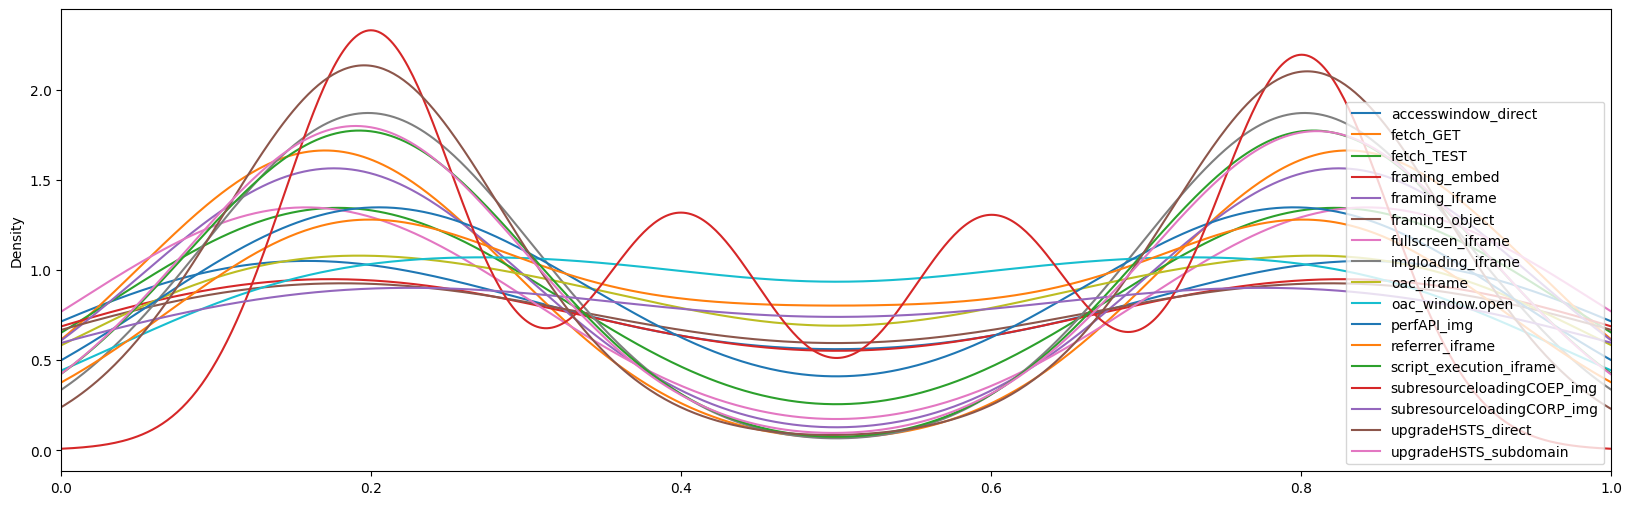

,,count
browser,test_name,
firefox_beta Android 11 123.0b9 intent real,subresourceloadingCOEP_img,76
chrome iPadOS 17.3.1 122.0.6261.89 intent real,subresourceloadingCOEP_img,72
safari macOS 14.3.1 17.3.1 selenium real,subresourceloadingCOEP_img,57
firefox Ubuntu 22.04 123 selenium headless,subresourceloadingCOEP_img,46
firefox Ubuntu 22.04 121 selenium headless,subresourceloadingCOEP_img,46
firefox Ubuntu 22.04 122 selenium headless,subresourceloadingCOEP_img,33
firefox_beta Android 11 123.0b9 intent real,oac_iframe,18
brave Android 11 1.62.165 intent real,upgradeHSTS_direct,16
opera Android 11 80.5.4244.78163 intent real,accesswindow_direct,10


proportion
0.200000    1239
0.800000    1201
0.400000     368
0.600000     367
0.166667     122
0.833333     122
0.100000      44
0.900000      44
0.111111      37
0.888889      36
0.142857      34
0.857143      34
0.928571      16
0.866667      16
0.071429      16
0.133333      16
0.875000      15
0.125000      15
0.666667      14
0.333333      13
0.750000       8
0.250000       8
0.266667       7
0.700000       7
0.300000       7
0.733333       7
0.066667       6
0.933333       6
0.222222       6
0.777778       5
0.714286       3
0.285714       3
0.533333       3
0.047619       3
0.952381       3
0.466667       3
0.980769       2
0.785714       2
0.045455       2
0.954545       2
0.947368       2
0.019231       2
0.428571       2
0.052632       2
0.571429       2
0.214286       2
0.181818       2
0.727273       2
0.976190       1
0.642857       1
0.023810       1
0.923077       1
0.375000       1
0.625000       1
0.043478       1
0.956522       1
0.307692       1
0.692308       1
0.0

In [275]:
# What is the ration of different outcomes for tests with more than one outcome?
test = df.groupby(["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id", "browser", "resp_type"])['outcome_str'].value_counts(normalize=True).reset_index()

# General information on tests with more than one outcome
mean_max_value = test.loc[test["proportion"] != 1.0].groupby(["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id", "browser", "resp_type"])["proportion"].max().reset_index()
display(mean_max_value["proportion"].agg(["count", "mean", "std", "min", "median", "max"]))        
display(mean_max_value.groupby("test_name")["proportion"].agg(["count", "mean", "std", "min", "median", "max"]))

# Tests where the most common and second most commont outcome is close (majority vote only is between 0.5 and 0.79) -> noisy test, majority vote might be wrong?
display(test.loc[(test['proportion'] >= 0.5) & (test['proportion'] <= 0.79)]["test_name"].value_counts())

# As a density plot
ax = test.loc[test["proportion"] != 1.0].groupby("test_name")["proportion"].plot(kind="kde", xlim=(0, 1), legend=True, figsize=(20, 6))
ax.iloc[0].legend(loc='lower right')  # Customize the legend location
plt.show()

# Same grouped by browsers
display(test.loc[(test['proportion'] >= 0.5) & (test['proportion'] <= 0.79)].groupby("browser")["test_name"].value_counts().to_frame().sort_values(by="count", ascending=False))

# Raw value counts of proportions
with pd.option_context("display.max_rows", 77):
    display(test.loc[test["proportion"] != 1.0]["proportion"].value_counts())

### Majority Voting
- Perform majority voting
- Only firefox_beta Android 11 (basic) subresourceloadingCOEP_img has 8 tests with the same mode, we simply choose the first in such cases

In [269]:
df = df_org
df = df.loc[df["test_status"] == 0]

In [270]:
df_stab = df

# Only keep one row for each test
# If the test had non-deterministic results, use majority voting! (only works reliably if there a enough repetitions of the tests runs, >= 5)

print("Original data entries", len(df))

# Majority voting (pd.Series.mode returns the most frequest item) (quite slow)

df = df.groupby(["test_id", "browser"], observed=True)["outcome_str"].agg(pd.Series.mode).reset_index()
print("Only one row for each test (per browser; majority voting)", len(df))

Original data entries 12937445
Only one row for each test (per browser; majority voting) 2509220


In [271]:
# Merge back additional required properties!
# ["name", "test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id", "resp_type", "label", 'org_origin', 'resp_origin', 'status_code', 'raw_header']

df = df.merge(df_stab.drop_duplicates(subset=["test_id", "browser"]), on=["test_id", "browser"], how="left", suffixes=["", "_ignore"])


In [272]:
# Tests with same mode?! maybe rerun again?!
with pd.option_context("display.max_colwidth", None):
    # Firefox subresourceloadingCOEP_img
    # Ignore, indeterminisitc behavior.
    display(df.loc[(df["browser"] == 'firefox_beta Android 11 123.0b9 intent real') & (df['outcome_str'].apply(lambda x: isinstance(x, np.ndarray)))][["outcome_str", "full_url"]])

    # Duckduckgo oac, RP, COOP
    # Rerun all three groups with higher timeouts?
    display(df.loc[(df["browser"] == 'duckduckgo Android 11 5.194.0 intent real') & (df['outcome_str'].apply(lambda x: isinstance(x, np.ndarray)))][["outcome_str", "full_url"]])

    
    # Brave (Android) oac_window.open
    # Rerun one URL! -> fixed
    display(df.loc[(df["browser"] == 'brave Android 11 1.62.165 intent real') & (df['outcome_str'].apply(lambda x: isinstance(x, np.ndarray)))][["outcome_str", "full_url"]])

    # Opera (Android) ugrade_HSTS_direct
    # Rerun one URL! -> fixed
    display(df.loc[(df["browser"] == 'opera Android 11 80.5.4244.78163 intent real') & (df['outcome_str'].apply(lambda x: isinstance(x, np.ndarray)))][["outcome_str", "full_url"]])

,outcome_str,full_url
2177221,"[{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}]",http://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=10&resp_type=basic&browser_id=64&label=COEP&first_id=58&last_id=58&scheme=http&run_id=645058ab2c9143599e445a365f502857
2177235,"[{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}]",http://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=10&resp_type=basic&browser_id=64&label=COEP&first_id=59&last_id=59&scheme=http&run_id=141f1711bc294e1db4f626281598088a
2177319,"[{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}]",http://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=10&resp_type=basic&browser_id=64&label=COEP&first_id=65&last_id=65&scheme=http&run_id=50b6106d332c437f8a76f52d34f6bbb6
2177641,"[{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}]",http://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=10&resp_type=basic&browser_id=64&label=COEP&first_id=66&last_id=66&scheme=http&run_id=db5f71465546446eacf64876591928e2
2177767,"[{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}]",http://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=10&resp_type=basic&browser_id=64&label=COEP&first_id=64&last_id=64&scheme=http&run_id=f0376075d30b402585774303b11dcda4
2177795,"[{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}]",http://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=10&resp_type=basic&browser_id=64&label=COEP&first_id=66&last_id=66&scheme=http&run_id=db5f71465546446eacf64876591928e2
2215385,"[{'image-events': {'swag.jpg': 'error', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}]",https://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=10&resp_type=basic&browser_id=64&label=COEP&first_id=59&last_id=59&scheme=https&run_id=c38e1479189245d8a7b5ec707d79f6a0
2215847,"[{'image-events': {'swag.jpg': 'error', 'swag-same-site.

,outcome_str,full_url


,outcome_str,full_url


,outcome_str,full_url


In [273]:
# If several values occur the same, the mode is an np.ndarray and not a string!
# If we have exactly 5 repetitions for each test, the issue cannot exist!
# However, our repeat system only enables us to have 5+ results for each test
print("Tests with the same mode (highest frequency outcome):")
display(df.loc[df['outcome_str'].apply(lambda x: isinstance(x, np.ndarray))].groupby(["browser", "resp_type", "test_name"])["outcome_str"].count())

# In the rare cases, where it actually matters, we can just take the first? (this might be noise in the generated trees and other summaries!)
# These are unstable tests that might indicate random behavior in the browser (e.g., firefox COEP_img)
df['outcome_str'] = df['outcome_str'].apply(lambda x: x[0] if isinstance(x, np.ndarray) else x)

Tests with the same mode (highest frequency outcome):


browser                                      resp_type  test_name                 
firefox_beta Android 11 123.0b9 intent real  basic      subresourceloadingCOEP_img    8
Name: outcome_str, dtype: int64

# Browser differences
- Most tests have one outcome only (not interesting for us)
- 8169 tests have two outcomes, 87 tests have three outcomes
- All test rows: 2509220, should be: 2509220, Rows with more than one outcome: 115584, Tests with more than one outcome: 8256

In [25]:
# Most tests have exactly one outcome, quite some have two, couple have three!
res = df.groupby(["resp_type", "test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id", "test_id"], observed=True)
res = res["outcome_str"].agg("nunique")
display(res.value_counts().to_frame())

,count
outcome_str,
1,170974
2,8169
3,87


## Differences per test group
- Basic:
    - subresourceloadingCORP_object 100% of test have different results (WebKit does not support postMessages on objects?)
    - couple of others have 20%+ differences
    - others have 0% 
- Parsing:
    - oac_window.open has 99% (only supported in chromium)
    - other tests with differences are between 0.5% (fetch_GET) and 5% (upgradeHSTS_direct)

In [26]:
# Basic:
# subresourceloadingCORP_object has different results for 100% of tests
# couple of others have 20%+ differences
# couple have 0%

# Parsing:
# oac_window.open has 99%
# Other test groups have between 0.5 - 5% of tests with different outcomes
r = res.reset_index()
r["diff"] = r["outcome_str"] != 1
r.groupby(["resp_type", "test_name", "relation_info"])["diff"].agg(["count", "sum", "mean"]).sort_values("mean", ascending=False)

count   sum      mean
resp_type test_name                     relation_info                        
basic     subresourceloadingCORP_object direct            176   176  1.000000
parsing   oac_window.open               window.open      3398  3370  0.991760
basic     oac_window.open               window.open       224   192  0.857143
          oac_iframe                    direct            224   144  0.642857
                                        sandbox           224   144  0.642857
          subresourceloadingCOEP_img    direct            176    88  0.500000
          referrer_iframe               window.open       256   120  0.468750
          fullscreen_iframe             direct            384   142  0.369792
          framing_embed                 direct            560   186  0.332143
          framing_object                direct            560   186  0.332143
          fullscreen_iframe             child_allow       384   113  0.294271
          perfAPI_img                   direct            208    55  0.264423
          framing_object                sandbox           560   120  0.214286
                                        nested            560   120  0.214286
          framing_embed                 nested            560   120  0.214286
                                        sandbox           560   120  0.214286
          accesswindow_direct           direct            176    28  0.159091
          script_execution_iframe       sandbox           272    21  0.077206
          referrer_iframe               iframe            256    18  0.070312
          fullscreen_iframe             child             384    23  0.059896
          imgloading_iframe             direct            272    13  0.047794
parsing   upgradeHSTS_direct            direct           6648   312  0.046931
          fullscreen_iframe             child_allow      7760   355  0.045747
          imgloading_iframe             direct           5420   230  0.042435
          script_execution_iframe       direct           5452   216  0.039618
basic     upgradeHSTS_direct            direct             28     1  0.035714
parsing   fullscreen_iframe             direct           7760   272  0.035052
basic     subresourceloadingCOEP_img    sandbox           176     4  0.022727
parsing   subresourceloadingCOEP_img    direct           5274   110  0.020857
          framing_iframe                direct          17560   365  0.020786
          referrer_iframe               iframe           5594   101  0.018055
          upgradeHSTS_subdomain         subdomain        6648   101  0.015193
basic     framing_iframe                sandbox           560     8  0.014286
parsing   perfAPI_img                   direct           3202    33  0.010306
          subresourceloadingCORP_img    direct           6714    68  0.010128
          accesswindow_direct           direct           5312    44  0.008283
          framing_iframe                nested          17560   144  0.008200
          fetch_GET                     simple          16118   104  0.006452
                                        custom_headers  16118   101  0.006266
          fetch_TEST                    custom_method   16118   101  0.006266
basic     subresourceloadingCORP_img    direct            176     1  0.005682
parsing   fetch_GET                     credentials     16118    86  0.005336
basic     fetch_GET                     credentials        96     0  0.000000
                                        simple             96     0  0.000000
                                        custom_headers     96     0  0.000000
          fullscreen_iframe             child_sandbox     384     0  0.000000
          framing_iframe                nested            560     0  0.000000
                                        direct            560     0  0.000000
          fetch_TEST                    custom_method      96     0  0.000000
          upgradeHSTS_subdomain         subdomain          28     0  0.000000


In [27]:
# Select only test rows with more than one outcome
tests_with_mult_outcomes = r.loc[r["diff"]].set_index(["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id"])
df_mult = df.loc[df[["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id"]].apply(tuple, axis=1).isin(tests_with_mult_outcomes.index)]
tests_with_more_than_one_outcome = df_mult.drop_duplicates(subset=["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id"])


all_tests_should_be =  df_org.loc[df_org["test_status"] == 0]["test_id"].nunique() * df_org["browser"].nunique() # (num parsing tests + num_basic_tests) * num_browsers (168774+10456)
print(f"All test rows: {len(df)}, should be: {all_tests_should_be}, Rows with more than one outcome: {len(df_mult)}, Tests with more than one outcome: {len(tests_with_more_than_one_outcome)}")

All test rows: 2509220, should be: 2509220, Rows with more than one outcome: 115584, Tests with more than one outcome: 8256


## Browser similarity
- Matrix for differences between all browsers split by all results, only parsing, only basic, only specific test types
- In general:
    - Chromium != Firefox != WebKit
    - Brave is different to Chrome (whereas Opera, Edge are equal to Chrome?)
    - Firefox and WebKit are close together
    - Differences between Mobile and Desktop exist but are small (for all brave, chrome, firefox, safari)

In [30]:
# Simmilarity between browsers and versions!
# (Current issue: displays a difference if one browser has no result at all; in the end we have 5+ stable results for each tests, thus it should not be an issue anymore)

# Function to calculate absolute and percentage overlap
def calculate_overlap(df, col1, col2):
    df = df[[col1, col2]].dropna()
    df.columns.values[0] = 0
    df.columns.values[1] = 1
    absolute_overlap = (df[0] == df[1]).sum()
    unique_rows = len(df)
    diff_rows = unique_rows - absolute_overlap
    percentage_diff = (diff_rows / unique_rows) * 100
    return diff_rows, percentage_diff, unique_rows


def display_overlap(df, show_all=True, name="All"):
    print(name)
    sim_frame = df.set_index(["test_id", "browser"])["outcome_str"].unstack().astype("str")
    sim_frame = sim_frame.reset_index().drop(columns=["test_id"])
    # Create a dictionary to store results
    results = {}
    matrix = {}
    
    # Iterate through all pairs of columns
    for i, col1 in enumerate(sim_frame.columns):
        for col2 in sim_frame.columns:
            key = f"{col1}_vs_{col2}"
            results[key] = calculate_overlap(sim_frame, col1, col2)
            try:
                l = matrix[col1]
            except KeyError:
                l = {}
            # 0 for absolute count of differences, 1 for percentage
            l[col2] = results[key][0]
            matrix[col1] = l
            
    
    # Convert the results to a DataFrame for better visualization
    results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Absolute Diff', 'Percentage Diff', "Count"])
    
    # Display difference matrix
    with pd.option_context("display.max_columns", 28):
        if show_all:
            # TODO: use a custom Order (e.g., all Android, or some chromium versions next to each other)
            display(pd.DataFrame(matrix))
        else:
            display(pd.DataFrame(matrix).drop_duplicates().T)


display_overlap(df)

for name, group in df.groupby("resp_type"):
    display_overlap(group, show_all=True, name=name)

for name, group in df.groupby("test_name"):
    display_overlap(group, show_all=False, name=name)

All


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,151,81,100,101,101,6622,101,6963,6960,6958,6971,124,6653
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,151,0,161,141,142,142,6568,142,6896,6893,6891,6930,180,6607
chrome Android 11 121.0.6167.180 intent real,81,161,0,20,21,21,6603,21,6931,6928,6926,6939,48,6634
chrome Ubuntu 22.04 120 selenium headless-new,100,141,20,0,1,1,6609,1,6923,6920,6918,6957,44,6648
chrome Ubuntu 22.04 121 selenium headless-new,101,142,21,1,0,0,6610,0,6924,6921,6919,6958,45,6649
chrome Ubuntu 22.04 122 selenium headless-new,101,142,21,1,0,0,6610,0,6924,6921,6919,6958,45,6649
chrome iPadOS 17.3.1 122.0.6261.89 intent real,6622,6568,6603,6609,6610,6610,0,6610,2788,2785,2781,2812,6583,103
edge Ubuntu 22.04 121 selenium headless-new,101,142,21,1,0,0,6610,0,6924,6921,6919,6958,45,6649
firefox Ubuntu 22.04 121 selenium headless,6963,6896,6931,6923,6924,6924,2788,6924,0,27,33,90,6897,2729
firefox Ubuntu 22.04 122 selenium headless,6960,6893,6928,6920,6921,6921,2785,6921,27,0,38,83,6894,2732


basic


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,63,76,82,83,83,1966,83,1036,1036,1037,1060,106,2019
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,63,0,77,71,72,72,1986,72,1055,1055,1056,1079,106,2039
chrome Android 11 121.0.6167.180 intent real,76,77,0,6,7,7,1951,7,1007,1007,1008,1031,34,2004
chrome Ubuntu 22.04 120 selenium headless-new,82,71,6,0,1,1,1957,1,1013,1013,1014,1037,40,2010
chrome Ubuntu 22.04 121 selenium headless-new,83,72,7,1,0,0,1958,0,1014,1014,1015,1038,41,2011
chrome Ubuntu 22.04 122 selenium headless-new,83,72,7,1,0,0,1958,0,1014,1014,1015,1038,41,2011
chrome iPadOS 17.3.1 122.0.6261.89 intent real,1966,1986,1951,1957,1958,1958,0,1958,1166,1166,1167,1204,1927,53
edge Ubuntu 22.04 121 selenium headless-new,83,72,7,1,0,0,1958,0,1014,1014,1015,1038,41,2011
firefox Ubuntu 22.04 121 selenium headless,1036,1055,1007,1013,1014,1014,1166,1014,0,12,15,54,983,1117
firefox Ubuntu 22.04 122 selenium headless,1036,1055,1007,1013,1014,1014,1166,1014,12,0,15,54,983,1117


parsing


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,88,5,18,18,18,4656,18,5927,5924,5921,5911,18,4634
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,88,0,84,70,70,70,4582,70,5841,5838,5835,5851,74,4568
chrome Android 11 121.0.6167.180 intent real,5,84,0,14,14,14,4652,14,5924,5921,5918,5908,14,4630
chrome Ubuntu 22.04 120 selenium headless-new,18,70,14,0,0,0,4652,0,5910,5907,5904,5920,4,4638
chrome Ubuntu 22.04 121 selenium headless-new,18,70,14,0,0,0,4652,0,5910,5907,5904,5920,4,4638
chrome Ubuntu 22.04 122 selenium headless-new,18,70,14,0,0,0,4652,0,5910,5907,5904,5920,4,4638
chrome iPadOS 17.3.1 122.0.6261.89 intent real,4656,4582,4652,4652,4652,4652,0,4652,1622,1619,1614,1608,4656,50
edge Ubuntu 22.04 121 selenium headless-new,18,70,14,0,0,0,4652,0,5910,5907,5904,5920,4,4638
firefox Ubuntu 22.04 121 selenium headless,5927,5841,5924,5910,5910,5910,1622,5910,0,15,18,36,5914,1612
firefox Ubuntu 22.04 122 selenium headless,5924,5838,5921,5907,5907,5907,1619,5907,15,0,23,29,5911,1615


accesswindow_direct


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome iPadOS 17.3.1 122.0.6261.89 intent real,firefox Ubuntu 22.04 121 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,15,4,33,63,53,20,25
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,15,0,11,40,56,68,7,40
chrome Android 11 121.0.6167.180 intent real,4,11,0,37,67,57,18,29
chrome Ubuntu 22.04 120 selenium headless-new,15,0,11,40,56,68,7,40
chrome Ubuntu 22.04 121 selenium headless-new,15,0,11,40,56,68,7,40
chrome Ubuntu 22.04 122 selenium headless-new,15,0,11,40,56,68,7,40
chrome iPadOS 17.3.1 122.0.6261.89 intent real,33,40,37,0,40,36,33,8
edge Ubuntu 22.04 121 selenium headless-new,15,0,11,40,56,68,7,40
firefox Ubuntu 22.04 121 selenium headless,63,56,67,40,0,12,49,40
firefox Ubuntu 22.04 122 selenium headless,63,56,67,40,0,12,49,40


fetch_GET


,brave Android 11 1.62.165 intent real,chrome iPadOS 17.3.1 122.0.6261.89 intent real,firefox Ubuntu 22.04 121 selenium headless
brave Android 11 1.62.165 intent real,0,94,291
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,94,291
chrome Android 11 121.0.6167.180 intent real,0,94,291
chrome Ubuntu 22.04 120 selenium headless-new,0,94,291
chrome Ubuntu 22.04 121 selenium headless-new,0,94,291
chrome Ubuntu 22.04 122 selenium headless-new,0,94,291
chrome iPadOS 17.3.1 122.0.6261.89 intent real,94,0,197
edge Ubuntu 22.04 121 selenium headless-new,0,94,291
firefox Ubuntu 22.04 121 selenium headless,291,197,0
firefox Ubuntu 22.04 122 selenium headless,291,197,0


fetch_TEST


,brave Android 11 1.62.165 intent real,chrome iPadOS 17.3.1 122.0.6261.89 intent real,firefox Ubuntu 22.04 121 selenium headless
brave Android 11 1.62.165 intent real,0,55,101
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,55,101
chrome Android 11 121.0.6167.180 intent real,0,55,101
chrome Ubuntu 22.04 120 selenium headless-new,0,55,101
chrome Ubuntu 22.04 121 selenium headless-new,0,55,101
chrome Ubuntu 22.04 122 selenium headless-new,0,55,101
chrome iPadOS 17.3.1 122.0.6261.89 intent real,55,0,46
edge Ubuntu 22.04 121 selenium headless-new,0,55,101
firefox Ubuntu 22.04 121 selenium headless,101,46,0
firefox Ubuntu 22.04 122 selenium headless,101,46,0


framing_embed


,brave Android 11 1.62.165 intent real,chrome iPadOS 17.3.1 122.0.6261.89 intent real
brave Android 11 1.62.165 intent real,0,426
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,426
chrome Android 11 121.0.6167.180 intent real,0,426
chrome Ubuntu 22.04 120 selenium headless-new,0,426
chrome Ubuntu 22.04 121 selenium headless-new,0,426
chrome Ubuntu 22.04 122 selenium headless-new,0,426
chrome iPadOS 17.3.1 122.0.6261.89 intent real,426,0
edge Ubuntu 22.04 121 selenium headless-new,0,426
firefox Ubuntu 22.04 121 selenium headless,0,426
firefox Ubuntu 22.04 122 selenium headless,0,426


framing_iframe


,brave Android 11 1.62.165 intent real,chrome iPadOS 17.3.1 122.0.6261.89 intent real,firefox Ubuntu 22.04 121 selenium headless
brave Android 11 1.62.165 intent real,0,95,517
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,95,517
chrome Android 11 121.0.6167.180 intent real,0,95,517
chrome Ubuntu 22.04 120 selenium headless-new,0,95,517
chrome Ubuntu 22.04 121 selenium headless-new,0,95,517
chrome Ubuntu 22.04 122 selenium headless-new,0,95,517
chrome iPadOS 17.3.1 122.0.6261.89 intent real,95,0,422
edge Ubuntu 22.04 121 selenium headless-new,0,95,517
firefox Ubuntu 22.04 121 selenium headless,517,422,0
firefox Ubuntu 22.04 122 selenium headless,517,422,0


framing_object


,brave Android 11 1.62.165 intent real,chrome iPadOS 17.3.1 122.0.6261.89 intent real
brave Android 11 1.62.165 intent real,0,426
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,426
chrome Android 11 121.0.6167.180 intent real,0,426
chrome Ubuntu 22.04 120 selenium headless-new,0,426
chrome Ubuntu 22.04 121 selenium headless-new,0,426
chrome Ubuntu 22.04 122 selenium headless-new,0,426
chrome iPadOS 17.3.1 122.0.6261.89 intent real,426,0
edge Ubuntu 22.04 121 selenium headless-new,0,426
firefox Ubuntu 22.04 121 selenium headless,0,426
firefox Ubuntu 22.04 122 selenium headless,0,426


fullscreen_iframe


,brave Android 11 1.62.165 intent real,chrome iPadOS 17.3.1 122.0.6261.89 intent real,firefox Ubuntu 22.04 121 selenium headless
brave Android 11 1.62.165 intent real,0,900,905
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,900,905
chrome Android 11 121.0.6167.180 intent real,0,900,905
chrome Ubuntu 22.04 120 selenium headless-new,0,900,905
chrome Ubuntu 22.04 121 selenium headless-new,0,900,905
chrome Ubuntu 22.04 122 selenium headless-new,0,900,905
chrome iPadOS 17.3.1 122.0.6261.89 intent real,900,0,9
edge Ubuntu 22.04 121 selenium headless-new,0,900,905
firefox Ubuntu 22.04 121 selenium headless,905,9,0
firefox Ubuntu 22.04 122 selenium headless,905,9,0


imgloading_iframe


,brave Android 11 1.62.165 intent real,chrome iPadOS 17.3.1 122.0.6261.89 intent real,firefox Ubuntu 22.04 121 selenium headless
brave Android 11 1.62.165 intent real,0,41,243
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,41,243
chrome Android 11 121.0.6167.180 intent real,0,41,243
chrome Ubuntu 22.04 120 selenium headless-new,0,41,243
chrome Ubuntu 22.04 121 selenium headless-new,0,41,243
chrome Ubuntu 22.04 122 selenium headless-new,0,41,243
chrome iPadOS 17.3.1 122.0.6261.89 intent real,41,0,202
edge Ubuntu 22.04 121 selenium headless-new,0,41,243
firefox Ubuntu 22.04 121 selenium headless,243,202,0
firefox Ubuntu 22.04 122 selenium headless,243,202,0


oac_iframe


,brave Android 11 1.62.165 intent real,chrome iPadOS 17.3.1 122.0.6261.89 intent real
brave Android 11 1.62.165 intent real,0,288
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,288
chrome Android 11 121.0.6167.180 intent real,0,288
chrome Ubuntu 22.04 120 selenium headless-new,0,288
chrome Ubuntu 22.04 121 selenium headless-new,0,288
chrome Ubuntu 22.04 122 selenium headless-new,0,288
chrome iPadOS 17.3.1 122.0.6261.89 intent real,288,0
edge Ubuntu 22.04 121 selenium headless-new,0,288
firefox Ubuntu 22.04 121 selenium headless,288,0
firefox Ubuntu 22.04 122 selenium headless,288,0


oac_window.open


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,firefox Ubuntu 22.04 121 selenium headless,opera Android 11 80.5.4244.78163 intent real
brave Android 11 1.62.165 intent real,0,13,3562,3562,23
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,13,0,3562,3562,10
chrome Android 11 121.0.6167.180 intent real,13,0,3562,3562,10
chrome Ubuntu 22.04 120 selenium headless-new,13,0,3562,3562,10
chrome Ubuntu 22.04 121 selenium headless-new,13,0,3562,3562,10
chrome Ubuntu 22.04 122 selenium headless-new,13,0,3562,3562,10
chrome iPadOS 17.3.1 122.0.6261.89 intent real,3562,3562,0,4,3562
edge Ubuntu 22.04 121 selenium headless-new,13,0,3562,3562,10
firefox Ubuntu 22.04 121 selenium headless,3562,3562,4,0,3562
firefox Ubuntu 22.04 122 selenium headless,3562,3562,4,0,3562


perfAPI_img


,brave Android 11 1.62.165 intent real,chrome iPadOS 17.3.1 122.0.6261.89 intent real,firefox Ubuntu 22.04 121 selenium headless,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,22,66,74
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,22,66,74
chrome Android 11 121.0.6167.180 intent real,0,22,66,74
chrome Ubuntu 22.04 120 selenium headless-new,0,22,66,74
chrome Ubuntu 22.04 121 selenium headless-new,0,22,66,74
chrome Ubuntu 22.04 122 selenium headless-new,0,22,66,74
chrome iPadOS 17.3.1 122.0.6261.89 intent real,22,0,88,52
edge Ubuntu 22.04 121 selenium headless-new,0,22,66,74
firefox Ubuntu 22.04 121 selenium headless,66,88,0,40
firefox Ubuntu 22.04 122 selenium headless,66,88,0,40


referrer_iframe


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,firefox Ubuntu 22.04 121 selenium headless,opera Android 11 80.5.4244.78163 intent real
brave Android 11 1.62.165 intent real,0,116,59,65,66,189,207,74
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,116,0,147,141,142,135,153,159
chrome Android 11 121.0.6167.180 intent real,59,147,0,6,7,170,174,17
chrome Ubuntu 22.04 120 selenium headless-new,65,141,6,0,1,176,180,23
chrome Ubuntu 22.04 121 selenium headless-new,66,142,7,1,0,177,181,24
chrome Ubuntu 22.04 122 selenium headless-new,66,142,7,1,0,177,181,24
chrome iPadOS 17.3.1 122.0.6261.89 intent real,189,135,170,176,177,0,26,153
edge Ubuntu 22.04 121 selenium headless-new,66,142,7,1,0,177,181,24
firefox Ubuntu 22.04 121 selenium headless,207,153,174,180,181,26,0,157
firefox Ubuntu 22.04 122 selenium headless,207,153,174,180,181,26,0,157


script_execution_iframe


,brave Android 11 1.62.165 intent real,chrome iPadOS 17.3.1 122.0.6261.89 intent real,firefox Ubuntu 22.04 121 selenium headless
brave Android 11 1.62.165 intent real,0,43,216
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,43,216
chrome Android 11 121.0.6167.180 intent real,0,43,216
chrome Ubuntu 22.04 120 selenium headless-new,0,43,216
chrome Ubuntu 22.04 121 selenium headless-new,0,43,216
chrome Ubuntu 22.04 122 selenium headless-new,0,43,216
chrome iPadOS 17.3.1 122.0.6261.89 intent real,43,0,215
edge Ubuntu 22.04 121 selenium headless-new,0,43,216
firefox Ubuntu 22.04 121 selenium headless,216,215,0
firefox Ubuntu 22.04 122 selenium headless,216,215,0


subresourceloadingCOEP_img


,brave Android 11 1.62.165 intent real,chrome iPadOS 17.3.1 122.0.6261.89 intent real,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,91,97,94,92,117,77
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,91,97,94,92,117,77
chrome Android 11 121.0.6167.180 intent real,0,91,97,94,92,117,77
chrome Ubuntu 22.04 120 selenium headless-new,0,91,97,94,92,117,77
chrome Ubuntu 22.04 121 selenium headless-new,0,91,97,94,92,117,77
chrome Ubuntu 22.04 122 selenium headless-new,0,91,97,94,92,117,77
chrome iPadOS 17.3.1 122.0.6261.89 intent real,91,0,104,101,97,130,42
edge Ubuntu 22.04 121 selenium headless-new,0,91,97,94,92,117,77
firefox Ubuntu 22.04 121 selenium headless,97,104,0,27,33,76,94
firefox Ubuntu 22.04 122 selenium headless,94,101,27,0,38,69,97


subresourceloadingCORP_img


,brave Android 11 1.62.165 intent real,chrome iPadOS 17.3.1 122.0.6261.89 intent real,firefox Ubuntu 22.04 121 selenium headless,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,36,57,37
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,36,57,37
chrome Android 11 121.0.6167.180 intent real,0,36,57,37
chrome Ubuntu 22.04 120 selenium headless-new,0,36,57,37
chrome Ubuntu 22.04 121 selenium headless-new,0,36,57,37
chrome Ubuntu 22.04 122 selenium headless-new,0,36,57,37
chrome iPadOS 17.3.1 122.0.6261.89 intent real,36,0,45,1
edge Ubuntu 22.04 121 selenium headless-new,0,36,57,37
firefox Ubuntu 22.04 121 selenium headless,57,45,0,44
firefox Ubuntu 22.04 122 selenium headless,57,45,0,44


subresourceloadingCORP_object


,brave Android 11 1.62.165 intent real,chrome iPadOS 17.3.1 122.0.6261.89 intent real,firefox Ubuntu 22.04 121 selenium headless
brave Android 11 1.62.165 intent real,0,176,32
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,176,32
chrome Android 11 121.0.6167.180 intent real,0,176,32
chrome Ubuntu 22.04 120 selenium headless-new,0,176,32
chrome Ubuntu 22.04 121 selenium headless-new,0,176,32
chrome Ubuntu 22.04 122 selenium headless-new,0,176,32
chrome iPadOS 17.3.1 122.0.6261.89 intent real,176,0,176
edge Ubuntu 22.04 121 selenium headless-new,0,176,32
firefox Ubuntu 22.04 121 selenium headless,32,176,0
firefox Ubuntu 22.04 122 selenium headless,32,176,0


upgradeHSTS_direct


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome iPadOS 17.3.1 122.0.6261.89 intent real,firefox Ubuntu 22.04 121 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real
brave Android 11 1.62.165 intent real,0,7,5,91,250,248,7
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,7,0,3,84,244,246,4
chrome Android 11 121.0.6167.180 intent real,5,3,0,87,247,245,3
chrome Ubuntu 22.04 120 selenium headless-new,7,0,3,84,244,246,4
chrome Ubuntu 22.04 121 selenium headless-new,7,0,3,84,244,246,4
chrome Ubuntu 22.04 122 selenium headless-new,7,0,3,84,244,246,4
chrome iPadOS 17.3.1 122.0.6261.89 intent real,91,84,87,0,282,284,88
edge Ubuntu 22.04 121 selenium headless-new,7,0,3,84,244,246,4
firefox Ubuntu 22.04 121 selenium headless,250,244,247,282,0,2,248
firefox Ubuntu 22.04 122 selenium headless,250,244,247,282,0,2,248


upgradeHSTS_subdomain


,brave Android 11 1.62.165 intent real,chrome iPadOS 17.3.1 122.0.6261.89 intent real,firefox Ubuntu 22.04 121 selenium headless
brave Android 11 1.62.165 intent real,0,54,68
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,54,68
chrome Android 11 121.0.6167.180 intent real,0,54,68
chrome Ubuntu 22.04 120 selenium headless-new,0,54,68
chrome Ubuntu 22.04 121 selenium headless-new,0,54,68
chrome Ubuntu 22.04 122 selenium headless-new,0,54,68
chrome iPadOS 17.3.1 122.0.6261.89 intent real,54,0,80
edge Ubuntu 22.04 121 selenium headless-new,0,54,68
firefox Ubuntu 22.04 121 selenium headless,68,80,0
firefox Ubuntu 22.04 122 selenium headless,68,80,0


## Decision trees
- Create decisison trees for all test rows that have different outcomes (not too helpful?!)
- For manual analysis

In [31]:
# Limit on responses that have more than one outcome!
# This will remove all the branches that are the same in all browsers (and make trees large and confusing)
condition = df.groupby(["test_id"], observed=True)["outcome_str"].transform("nunique") != 1
tree_df = df.loc[condition]
print("Remove tests that are the same in all browsers. Remaining rows:", len(tree_df))

Remove tests that are the same in all browsers. Remaining rows: 115584


In [32]:
# How many rows exist for tree creation
with pd.option_context("display.max_rows", 100):
    display(tree_df[["test_name", "label", "relation_info"]].value_counts())

test_name                      label       relation_info 
oac_window.open                OAC         window.open       49868
fullscreen_iframe              PP          child_allow        6552
                                           direct             5796
upgradeHSTS_direct             HSTS        direct             4382
imgloading_iframe              CSP-IMG     direct             3402
framing_iframe                 CSP-FA      direct             3066
script_execution_iframe        CSP-SCRIPT  direct             3024
subresourceloadingCOEP_img     COEP        direct             2772
subresourceloadingCORP_object  CORP        direct             2464
oac_iframe                     OAC         sandbox            2016
                                           direct             2016
referrer_iframe                RP          window.open        1680
                                           iframe             1666
framing_iframe                 CSP-FA      nested             1498
fram

In [33]:
h2o.init(nthreads=50, max_mem_size="100G", log_level="WARN")
h2o.no_progress()

base_dir = f"trees/{datetime.today().strftime('%Y-%m-%dT%H:%M')}" 

for group_name, group in tree_df.groupby(["test_name", "relation_info"]):
    print(group_name)
    pred_cols = ["browser", "org_origin", "resp_origin", "status_code", "raw_header"]
    group = group[["outcome_str", *pred_cols]]
    tree = make_tree(group, pred_cols, group_name, base_dir)
    # print(tree)


Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


('accesswindow_direct', 'direct')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('accesswindow_direct', 'direct'), datapoints: 1008
('fetch_GET', 'credentials')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('fetch_GET', 'credentials'), datapoints: 1204
('fetch_GET', 'custom_headers')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('fetch_GET', 'custom_headers'), datapoints: 1414
('fetch_GET', 'simple')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('fetch_GET', 'simple'), datapoints: 1456
('fetch_TEST', 'custom_method')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('fetch_TEST', 'custom_method'), datapoints: 1414
('framing_embed', 'direct')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('framing_embed', 'direct'), datapoints: 2604
('framing_embed', 'nested')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('framing_embed', 'nested'), datapoints: 1680
('framing_embed', 'sandbox')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('framing_embed', 'sandbox'), datapoints: 1680
('framing_iframe', 'direct')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('framing_iframe', 'direct'), datapoints: 5110
('framing_iframe', 'nested')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('framing_iframe', 'nested'), datapoints: 2016
('framing_iframe', 'sandbox')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('framing_iframe', 'sandbox'), datapoints: 112
('framing_object', 'direct')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('framing_object', 'direct'), datapoints: 2604
('framing_object', 'nested')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('framing_object', 'nested'), datapoints: 1680
('framing_object', 'sandbox')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('framing_object', 'sandbox'), datapoints: 1680
('fullscreen_iframe', 'child')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('fullscreen_iframe', 'child'), datapoints: 322
('fullscreen_iframe', 'child_allow')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('fullscreen_iframe', 'child_allow'), datapoints: 6552
('fullscreen_iframe', 'direct')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('fullscreen_iframe', 'direct'), datapoints: 5796
('imgloading_iframe', 'direct')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('imgloading_iframe', 'direct'), datapoints: 3402
('oac_iframe', 'direct')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('oac_iframe', 'direct'), datapoints: 2016
('oac_iframe', 'sandbox')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('oac_iframe', 'sandbox'), datapoints: 2016
('oac_window.open', 'window.open')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('oac_window.open', 'window.open'), datapoints: 49868
('perfAPI_img', 'direct')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('perfAPI_img', 'direct'), datapoints: 1232
('referrer_iframe', 'iframe')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('referrer_iframe', 'iframe'), datapoints: 1666
('referrer_iframe', 'window.open')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('referrer_iframe', 'window.open'), datapoints: 1680
('script_execution_iframe', 'direct')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('script_execution_iframe', 'direct'), datapoints: 3024
('script_execution_iframe', 'sandbox')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('script_execution_iframe', 'sandbox'), datapoints: 294
('subresourceloadingCOEP_img', 'direct')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('subresourceloadingCOEP_img', 'direct'), datapoints: 2772
('subresourceloadingCOEP_img', 'sandbox')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('subresourceloadingCOEP_img', 'sandbox'), datapoints: 56
('subresourceloadingCORP_img', 'direct')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('subresourceloadingCORP_img', 'direct'), datapoints: 966
('subresourceloadingCORP_object', 'direct')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('subresourceloadingCORP_object', 'direct'), datapoints: 2464
('upgradeHSTS_direct', 'direct')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('upgradeHSTS_direct', 'direct'), datapoints: 4382
('upgradeHSTS_subdomain', 'subdomain')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,42 days 0 hours 56 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('upgradeHSTS_subdomain', 'subdomain'), datapoints: 1414


# Manual analysis
- Noise check/Manual confirmation:
    - Android: http://134.96.225.54:8888/#!/control/emulator-5554

## Helpers

In [34]:
# Open Tree SVG
from IPython.display import display, HTML
import os

def open_tree(tree_name):
    directory = 'trees/'
    latest_tree_directory = max([os.path.join(directory, d) for d in os.listdir(directory)], key=os.path.getmtime)
    file_path = f"http://localhost:8888/files/analysis/{latest_tree_directory}/svg/{tree_name}.svg"
    html_link = f'<a href="{file_path}" target="_blank">Open {tree_name}.svg</a>'
    display(HTML(html_link))

open_tree("('accesswindow_direct', 'direct')")

In [35]:
def show_overlap(test_name, groupby=True, show_all=True):
    d = df.loc[df["test_name"] == test_name]
    if groupby:
        for name, group in d.groupby("resp_type"):
            display_overlap(group, show_all=show_all, name=name)
    else:
        display_overlap(d, show_all=show_all, name="all")


In [36]:
from io import StringIO
import ipywidgets as widgets
from utils import clickable
from functools import partial

class DataFrameWidget(widgets.VBox):
    def __init__(self, df, rows_per_page=20):
        self.df = df
        self.rows_per_page = rows_per_page
        self.page_index = 0
        self.total_pages = (len(df) - 1) // rows_per_page + 1
        
        self.output = widgets.Output()
        
        self.prev_button = widgets.Button(description='Prev')
        self.prev_button.on_click(self.prev_page)
        self.next_button = widgets.Button(description='Next')
        self.next_button.on_click(self.next_page)
        
        self.page_label = widgets.Label(value=f'Page: {self.page_index + 1} / {self.total_pages}')
        
        self.update_output()

        super().__init__(children=[self.output, 
                                   widgets.HBox([self.prev_button, self.next_button]),
                                   self.page_label])
    
    def update_output(self):
        start = self.page_index * self.rows_per_page
        end = min((self.page_index + 1) * self.rows_per_page, len(self.df))
        display_df = self.df.iloc[start:end]
        
        with self.output:
            self.output.clear_output()
            with pd.option_context("display.max_colwidth", 500):
                click_func = partial(clickable, "URL")
                display_df = display_df.style.format({'url': click_func})
                display(display_df)
        self.page_label.value = f'Page: {self.page_index + 1} / {self.total_pages}'
    
    def prev_page(self, _):
        if self.page_index > 0:
            self.page_index -= 1
            self.update_output()
    
    def next_page(self, _):
        if self.page_index < self.total_pages - 1:
            self.page_index += 1
            self.update_output()


def show_response_groups(test_name, relation=None):
    splits = {}
    d = tree_df.loc[tree_df["test_name"] == test_name]
    if relation:
        d = d.loc[d["relation_info"] == relation]
    for test_id, group in d.groupby("test_id", observed=True):
        key = group[["browser", "outcome_str"]].drop_duplicates().sort_values("browser")
        key = key.to_csv(index=False)
        try:
            splits[key].append(test_id)
        except (AttributeError, KeyError):
            splits[key] = [test_id]

    tab_contents = []
    
    for i, (key, values) in enumerate(splits.items()):        
        # Prepare content for the tab
        main_output = widgets.Output()
        with main_output:
            print(f"Group {i}")
            display(pd.read_csv(StringIO(key)).groupby("outcome_str")["browser"].unique().apply(sorted).to_dict())
            with pd.option_context("display.max_colwidth", 500):
                cur_data = tree_df.loc[tree_df["test_id"].isin(values)]
                example = cur_data.iloc[0]
                example_url = example["clean_url"]
                example_element_relation = example["test_name"].split("_")[1] + "_" + example["relation_info"]
                example_resp_origin = example["resp_origin"]
                example_resp_id = example["response_id"]
                example_url += f"&t_resp_id={example_resp_id}&t_element_relation={example_element_relation}&t_resp_origin={example_resp_origin}"
                display(example_url)
                
                d_data = cur_data.drop_duplicates(subset=["raw_header", "status_code", "org_origin", "resp_origin", "response_id"]).sort_values(by=["raw_header", "status_code", "org_origin", "resp_origin"])
                d_data["url"] = d_data["clean_url"] + "&t_resp_id=" + d_data["response_id"].astype(str) + "&t_element_relation=" + d_data["test_name"].apply(lambda x: x.split("_")[1]) + "_" + d_data["relation_info"] + "&t_resp_origin=" + d_data["resp_origin"]
                d_data = d_data[["raw_header", "status_code", "org_origin", "resp_origin", "response_id", "url"]]

                # Display the DataFrame
                display(DataFrameWidget(d_data))
        
        # Add the content to the tab
        tab_contents.append(main_output)
    
    # Create tabs
    tab = widgets.Tab()
    tab.children = tab_contents

    
    # Set tab titles
    for i in range(len(tab_contents)):
        tab.set_title(i, f"Group {i}")
    
    display(tab)
                
            

In [37]:
def show_outcome_nums(test_name):
    display(pd.concat([df.loc[df["test_name"] == test_name].pivot_table("test_id", "outcome_str", aggfunc="nunique"), tree_df.loc[tree_df["test_name"] == test_name].pivot_table("test_id", "outcome_str", aggfunc="nunique")], axis=1))

def show_response_nums(test_name):
    display(tree_df.loc[tree_df["test_name"] == test_name].groupby("resp_type")["raw_header"].unique().apply(len))
    display(df.loc[df["test_name"] == test_name].groupby("resp_type")["raw_header"].unique().apply(len))

## accesswindow_direct/COOP window-references-coop.sub.html
- Testfile: `window-references-coop.sub.html`
- Testnames: accesswindow_direct
- Header: COOP
- Basic:
    - Android chrome (121), Ubuntu chrome (120-122), edge (121), brave (121) are identical
    - Android: Opera + brave sligthly different?
    - Safari, Firefox (all platforms) are identical
    - The two groups have 28 differences
- Parsing:
    - Ubuntu chrome (120-122), edge (121), brave (121), opera (Android 121) are identical
    - Android: Brave + chrome identical
    - Firefox desktop identical
    - Safari almost identical to Chrome/Brave Android?
    - ...
- [x] Investigate complex differences:
    - Maybe: same-origin differences due to HTTPS upgrades vs no-upgrade? (basic; chrome auto updates?)
    - Maybe: \n and \r and similar interpreted differently
    - See below!
- [x] Confirm some of the strange cases on Android + iPad (are they noise?)
- **Small amount of noise**

In [38]:
test_name = 'accesswindow_direct'

In [39]:
# Tree
open_tree(f"('{test_name}', 'direct')")

In [40]:
df.loc[df["test_name"] == test_name].groupby("test_id", observed=True)["outcome_str"].nunique().value_counts()

outcome_str
1    5416
2      72
Name: count, dtype: int64

In [41]:
show_overlap(test_name, groupby=True, show_all=True)

basic


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,4,4,4,4,4,24,4,24,24,24,24,9,24
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,4,0,0,0,0,0,28,0,28,28,28,28,7,28
chrome Android 11 121.0.6167.180 intent real,4,0,0,0,0,0,28,0,28,28,28,28,7,28
chrome Ubuntu 22.04 120 selenium headless-new,4,0,0,0,0,0,28,0,28,28,28,28,7,28
chrome Ubuntu 22.04 121 selenium headless-new,4,0,0,0,0,0,28,0,28,28,28,28,7,28
chrome Ubuntu 22.04 122 selenium headless-new,4,0,0,0,0,0,28,0,28,28,28,28,7,28
chrome iPadOS 17.3.1 122.0.6261.89 intent real,24,28,28,28,28,28,0,28,0,0,0,0,21,0
edge Ubuntu 22.04 121 selenium headless-new,4,0,0,0,0,0,28,0,28,28,28,28,7,28
firefox Ubuntu 22.04 121 selenium headless,24,28,28,28,28,28,0,28,0,0,0,0,21,0
firefox Ubuntu 22.04 122 selenium headless,24,28,28,28,28,28,0,28,0,0,0,0,21,0


parsing


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,11,0,11,11,11,9,11,39,39,39,29,11,1
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,11,0,11,0,0,0,12,0,28,28,28,40,0,12
chrome Android 11 121.0.6167.180 intent real,0,11,0,11,11,11,9,11,39,39,39,29,11,1
chrome Ubuntu 22.04 120 selenium headless-new,11,0,11,0,0,0,12,0,28,28,28,40,0,12
chrome Ubuntu 22.04 121 selenium headless-new,11,0,11,0,0,0,12,0,28,28,28,40,0,12
chrome Ubuntu 22.04 122 selenium headless-new,11,0,11,0,0,0,12,0,28,28,28,40,0,12
chrome iPadOS 17.3.1 122.0.6261.89 intent real,9,12,9,12,12,12,0,12,40,40,40,36,12,8
edge Ubuntu 22.04 121 selenium headless-new,11,0,11,0,0,0,12,0,28,28,28,40,0,12
firefox Ubuntu 22.04 121 selenium headless,39,28,39,28,28,28,40,28,0,0,0,12,28,40
firefox Ubuntu 22.04 122 selenium headless,39,28,39,28,28,28,40,28,0,0,0,12,28,40


In [42]:
df.loc[df["test_name"] == test_name].pivot_table("test_id", "outcome_str", aggfunc="nunique")

,test_id
outcome_str,
{'window.open.opener': 'null'},196
"{'window.open.opener': 'object ""[object Window]""'}",5364


In [43]:
tree_df.loc[tree_df["test_name"] == test_name].pivot_table("test_id", "outcome_str", aggfunc="nunique")

,test_id
outcome_str,
{'window.open.opener': 'null'},72
"{'window.open.opener': 'object ""[object Window]""'}",72


In [44]:
with pd.option_context("display.max_colwidth", None):
    display(tree_df.loc[tree_df["test_name"] == test_name].groupby(["outcome_str", "browser"], observed=True)["id"].count().unstack(0))

outcome_str,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window]""'}"
browser,,
brave Android 11 1.62.165 intent real,41,31
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,56,16
chrome Android 11 121.0.6167.180 intent real,45,27
chrome Ubuntu 22.04 120 selenium headless-new,56,16
chrome Ubuntu 22.04 121 selenium headless-new,56,16
chrome Ubuntu 22.04 122 selenium headless-new,56,16
chrome iPadOS 17.3.1 122.0.6261.89 intent real,24,48
edge Ubuntu 22.04 121 selenium headless-new,56,16
firefox Ubuntu 22.04 121 selenium headless,24,48


In [45]:
# All response headers that (sometimes) result in different outcomes
tree_df.loc[tree_df["test_name"] == test_name].groupby("resp_type")["raw_header"].unique().to_list()

[array(["[['Cross-Origin-Opener-Policy', 'same-origin-allow-popups']]",
        "[['Cross-Origin-Opener-Policy', 'same-origin']]",
        "[['Cross-Origin-Opener-Policy', 'same-origin-allow-popups'], ['location', 'https://sub.headers.websec.saarland/_hp/common/empty.html']]",
        "[['Cross-Origin-Opener-Policy', 'same-origin'], ['location', 'https://sub.headers.websec.saarland/_hp/common/empty.html']]"],
       dtype=object),
 array(["[['\\ncross-origin-opener-policy', 'unsafe-none']]",
        "[['cross-origin-opener-policy ', 'same-origin']]",
        "[['\\ncross-origin-opener-policy', 'same-origin']]",
        "[['cross-origin-opener-policy  ', 'same-origin']]",
        "[['cross-origin-opener-policy\\t', 'same-origin']]",
        "[['cross-origin-opener-policy\\r', 'same-origin']]",
        "[['\\rcross-origin-opener-policy', 'same-origin']]",
        "[['cross-origin-opener-policy ', 'same-origin-allow-popups']]",
        "[['\\ncross-origin-opener-policy', 'same-origin-allo

In [46]:
# Below analysis was done without duckduckgo results!

# Group 0: COOP only active on HTTPS, even though resp_origin is HTTP COOP is active in chromium-based browsers due to HTTPS auto-upgrade; Opera wrong group due to noise?
# Group 1: same; Opera correct
# Group 2: download triggered due to \n in response. Safari (+ Android without Opera?) download pages are treated similarily to about:blank?
# Group 3: \r, \t, or space at the beginning or end of header name allowed in all non-firefox browsers; real finding? which behavior is correct?
# Group 4: Two different findings; 1. Two headers, one empty: COOP active in Firefox, not-active in other browsers (which behavior is correct?), 2. \r at the end of the header name: works in Firefox, does not work in the other browsers!
# Group 5: Status code 204 + COOP works on iPad; does not work in other browsers (bug?)
# Group 6: Same/similar to group 2? (only iPad is on the other group?)
# Group 7: Similar to 0 and 1? Brave Android maybe in the incorrect group for some reason?
# Group 8: Similar to 0, 1, 7? Brave Android + opera maybe in the wrong group?
# Group 9: Similar to group 2 and 6? 2 Android browsers are in the other group however (might be noise?)

# Noise check/Manual confirmation:
# Android: http://134.96.225.54:8888/#!/control/emulator-5554

# Difficult?!
# Group 0 opera appears to be in the other group, recorded result was noise?
# Group 1 confirmed
# Group 7 brave is in the firefox group?, recorded result was no noise? (what is the difference to 0-1?); however opera is also in the firefox group (recorded result was noise?)
# Group 8 opera + brave stay the same/no noise; actual difference might be: only chrome applies redirect + COOP!
# Difference between (0,1) and (7,8) is that the latter uses http://sub.headers.websec.saarland; seems like opera + brave do not auto-update this origin (exception?)

# Group 2: confirmed
# Group 6: confirmed iPad is in the other group; not sure why? probably COOP applies before the download? (the difference between 2 is that \n is at the end, and the difference to 9 is that the COOP value is blocking)
# Group 9: all Android (except Opera) in the other group (noise in the results?, brave + chrome in wrong group!)

# Final Groups?:
# 0,1 (opera had noise)
# 2,9 (brave + chrome had noise)
# 3
# 4 (actual two different things in this group)
# 5
# 6
# 7,8 (opera had noise)

show_response_groups(test_name)

In [47]:
# How often do various status codes exist?
df.loc[df["test_name"] == test_name].groupby("browser")["status_code"].value_counts().to_frame()

count
browser                                  status_code       
brave Android 11 1.62.165 intent real    200           5396
                                         302             38
                                         203              6
                                         204              6
                                         300              6
...                                                     ...
safari macOS 14.3.1 17.3.1 selenium real 400              6
                                         403              6
                                         404              6
                                         500              6
                                         418              6

[154 rows x 1 columns]

## Fetch/CORS 
- Testfile: `fetch-cors.sub.html`
- Testnames: `fetch_GET_credentials|custom_headers_simple, fetch_TEST_custom_method`
- Headers: ACAO, ACAM, ACAH, ACAC, ACEH
- Basic + Parsing, ...
- **Small amount of noise?**

In [48]:
test_name = 'fetch_GET' # fetch_TEST

In [49]:
# Trees
open_tree("('fetch_GET', 'credentials')")
open_tree("('fetch_GET', 'custom_headers')")
open_tree("('fetch_GET', 'simple')")
open_tree("('fetch_TEST', 'custom_method')")

In [50]:
show_outcome_nums(test_name)

,test_id,test_id
outcome_str,,
"{'error': 'null', 'headers': ''}",3,3.0
"{'error': 'null', 'headers': 'access-control-allow-credentials,access-control-allow-headers,access-control-allow-methods,access-control-allow-origin,access-control-expose-headers,content-length,date,location,server,test,'}",1,1.0
"{'error': 'null', 'headers': 'access-control-allow-credentials,access-control-allow-headers,access-control-allow-methods,access-control-allow-origin,access-control-expose-headers,content-length,date,server,test,'}",91,12.0
"{'error': 'null', 'headers': 'access-control-allow-credentials,access-control-allow-origin,content-length,date,server,test,'}",6,NaN
"{'error': 'null', 'headers': 'access-control-allow-credentials,content-length,date,server,test,'}",6,NaN
"{'error': 'null', 'headers': 'access-control-allow-origin,cache-control,content-type,date,server,'}",6,NaN
"{'error': 'null', 'headers': 'access-control-allow-origin,content-length,date,server,test,'}",6,NaN
"{'error': 'null', 'headers': 'cache-control,content-type,'}",35,10.0
"{'error': 'null', 'headers': 'content-length,'}",4516,49.0


In [51]:
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

resp_type
parsing    96
Name: raw_header, dtype: int64

resp_type
basic         6
parsing    7969
Name: raw_header, dtype: int64

In [52]:
# Simple
# 0: 2 differences, Firefox vs All: 1. Firefox allows \r at the end of headers 2. Firefox allows two acao header with '' and with '*'
# 1: Firefox vs All: Firefox times out if \n in a response to fetch
# 2: Safari (MacOS) vs all: noise?
# 3: Firefox vs all: Firefox fails fetch if either starts with \r or ends with space or \t
# 4: Firefox vs all: Only Firefox redirects for status code 300
# 5: Firefox vs all: similar to 1, firefox times out if \n in a response
# 6: Chromium-based vs others: \x00 not allowed in Chromium
# 7: Firefox vs all: similar to 3
# 8: similar to 6
# 9: Firefox vs all: Only Firefox allows \r at end of header or at the start of the value
# 10: similar to 3
# 11: similar to 9
# 12: similar to 4
show_response_groups(test_name, relation="simple")

In [53]:
# credentials
# 0: Firefox vs all: \n timeout
# 1: Safari noise
# 2: Only firefox allows double acac + \r at the end of headers
# 3: Firefox does not allow \r at the beginnig of headers or \t and space at the end
# 4: Chromium does not allow \x00
# 5: same as 4
# 6: same as 3
# 7: Firefox vs all: Only Firefox allows \r at end of header or at the start of the value
# 8: only firefox redirects for 300
show_response_groups(test_name, relation="credentials")

In [54]:
# custom_headers
# 0: Only firefox allows \r and double header
# 1: Firefox + WebKit abort if \n in response?
# 2: Safari noise
# 3: Firefox \r, \t and space
# 4: \x00
# 5: same as 3
# 6: \x00
# 7: same as 0
# 8: same as 3
# 9: same as 0
show_response_groups(test_name, relation="custom_headers")

In [55]:
# custom_method
# 0: Firefox \r + double header
# 1: \n in response
# 2: safari noise
# 3: Firefox \r, \t, space
# 4: \x00
# 5: Firefox \r, \t, space
# 6: \x00
# 7: Firefox \r in value + end of header
# 8: Firefox \r, \t, space
# 9: Firefox \r in value + end of header
show_response_groups("fetch_TEST", relation="custom_method")

## Framing
- Testfile: `framing.sub.html`
- Testnames: `framing_embed`, `framing_iframe`, `framing_object` all `direct`, `nested`, and `sandbox`
- Headers: XFO, CSP, XFOvsCSP
- **Current manual analysis in this section was done with duckduckgo**
- **No noise**

In [56]:
test_name = 'framing_iframe' # framing_embed, framing_object (direct, nested, sandbox)

In [57]:
# Trees
open_tree("('framing_iframe', 'direct')")
open_tree("('framing_iframe', 'nested')")
open_tree("('framing_iframe', 'sandbox')")
open_tree("('framing_embed', 'direct')")
open_tree("('framing_embed', 'nested')")
open_tree("('framing_embed', 'sandbox')")
open_tree("('framing_object', 'direct')")
open_tree("('framing_object', 'nested')")
open_tree("('framing_object', 'sandbox')")

In [58]:
show_overlap(test_name, groupby=True, show_all=True)

basic


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,0,0,0,0,0,0,0,8,8,8,8,0,0
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,0,0,0,0,0,0,0,8,8,8,8,0,0
chrome Android 11 121.0.6167.180 intent real,0,0,0,0,0,0,0,0,8,8,8,8,0,0
chrome Ubuntu 22.04 120 selenium headless-new,0,0,0,0,0,0,0,0,8,8,8,8,0,0
chrome Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,0,0,8,8,8,8,0,0
chrome Ubuntu 22.04 122 selenium headless-new,0,0,0,0,0,0,0,0,8,8,8,8,0,0
chrome iPadOS 17.3.1 122.0.6261.89 intent real,0,0,0,0,0,0,0,0,8,8,8,8,0,0
edge Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,0,0,8,8,8,8,0,0
firefox Ubuntu 22.04 121 selenium headless,8,8,8,8,8,8,8,8,0,0,0,0,8,8
firefox Ubuntu 22.04 122 selenium headless,8,8,8,8,8,8,8,8,0,0,0,0,8,8


parsing


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,0,0,0,0,0,95,0,509,509,509,509,0,95
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,0,0,0,0,0,95,0,509,509,509,509,0,95
chrome Android 11 121.0.6167.180 intent real,0,0,0,0,0,0,95,0,509,509,509,509,0,95
chrome Ubuntu 22.04 120 selenium headless-new,0,0,0,0,0,0,95,0,509,509,509,509,0,95
chrome Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,95,0,509,509,509,509,0,95
chrome Ubuntu 22.04 122 selenium headless-new,0,0,0,0,0,0,95,0,509,509,509,509,0,95
chrome iPadOS 17.3.1 122.0.6261.89 intent real,95,95,95,95,95,95,0,95,414,414,414,414,95,0
edge Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,95,0,509,509,509,509,0,95
firefox Ubuntu 22.04 121 selenium headless,509,509,509,509,509,509,414,509,0,0,0,0,509,414
firefox Ubuntu 22.04 122 selenium headless,509,509,509,509,509,509,414,509,0,0,0,0,509,414


In [59]:
show_outcome_nums(test_name)

,test_id,test_id
outcome_str,,
message send,21769,517
message timeout,15548,517


In [60]:
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

resp_type
basic        1
parsing    222
Name: raw_header, dtype: int64

resp_type
basic        32
parsing    8726
Name: raw_header, dtype: int64

In [61]:
# Direct
# 0: Duckduckgo (Webview 83) does not support various frame-ancestor value misspellings (empty, NoNe, \t, ...)
# 1: Firefox+Safari vs Chromium-based (2 issues): 1. uppercase scheme not allowed in chrome (bug), 2. \x00 not allowed in chrome (unclear?)
# 2: Firefox vs the others (only firefox allows): 
# - 1. Firefox ignores path for FA, Others do not even allow the correct path? (What is the correct behavior according to the specs?)
# - 2. Firefox does not allow \r at the beginning of a header name or space and \t at the end
# - 3. Firefox does not allow \x0b (vertical tab) at the beginning or end of header value
# 3: Firefox vs the others (only firefox disallows):
# - 1. Firefox allows \r at the beginning of header values
# - 2. Only Firefox redirects for status code 300
# - 3. \x0b (vertical tab) not ignored in Firefox, thus *\x0b != *
# - 4. Only Firefox allows \r at the end of a header name
# - 5. XFO: firefox allows space, \r, \t, \x0c (form feed) anywhere!
# 4: Firefox + duckduckgo(Webview 83): \x01 - \x08, \x0e, \x0f, \x10 - \x1f, \x7f after * -> *\xNN -> blocked, after 'none'\xNN -> blocked (other browsers declare the full directive as invalid -> allowed?)
# 5: Duckduckgo (Webview 83): \xa0a, ´, “, ... leads to response being blocked
# 6: Firefox + Safari vs Chromium based: */ -> blocked in Firefox/Safari, allowed in Chromium?
show_response_groups(test_name, relation="direct")

In [62]:
# Nested
# More or less identical to `direct`? Some differences due to the fact that it is nested and the chain does not fullfill everything
show_response_groups(test_name, relation="nested")

In [63]:
# Sandbox
# 0: Duckduckgo vs the rest: 1. mixed content blocking not working correctly?, 2. frame-ancestors without a value not working
# 1: Firefox vs the rest: `frame-ancestors *` matches sandboxed frame, does not match in the other browsers (compare https://www.w3.org/TR/CSP3/#match-url-to-source-expression)
# Error message in Chrome is wrong/misleading (Safari as well). However behavior is correct, `sandbox` without `allow-same-origin` is an opaque origin that should not be matched by *
show_response_groups(test_name, relation="sandbox")

In [64]:
# Embed direct
# 0: WebKit does not allow embeds/postMessages for embeds
# 1: Duckduckgo allows `CSP: frame-ancestors`
show_response_groups("framing_embed", relation="direct")

In [65]:
# Embed nested
# Same as embed direct?
show_response_groups("framing_embed", relation="nested")

In [66]:
# Embed sandbox
# Same as embed nested
show_response_groups("framing_embed", relation="sandbox")

In [67]:
# Object direct
# Same as embed direct
show_response_groups("framing_object", relation="direct")

In [68]:
# Object nested
# Same as embed nested
show_response_groups("framing_object", relation="nested")

In [69]:
# Object sandbox
# Same as embed sandbox
show_response_groups("framing_object", relation="sandbox")

## Fullscreen/PP
- Testfile: `fullscreen-api-pp.sub.hml`
- Testnames: `fullscreen_iframe` with `direct`, `child`, `child_allow`, `child_sandbox`
- Headers: PP/FP
- **Current manual analysis in this section was done with duckduckgo**
- **No noise**

In [70]:
test_name = 'fullscreen_iframe' 

In [71]:
# Trees
open_tree("('fullscreen_iframe', 'direct')")
open_tree("('fullscreen_iframe', 'child')")
open_tree("('fullscreen_iframe', 'child_allow')")
open_tree("('fullscreen_iframe', 'child_sandbox')")

In [72]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,0,0,0,0,0,278,0,278,278,278,278,0,278
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,0,0,0,0,0,278,0,278,278,278,278,0,278
chrome Android 11 121.0.6167.180 intent real,0,0,0,0,0,0,278,0,278,278,278,278,0,278
chrome Ubuntu 22.04 120 selenium headless-new,0,0,0,0,0,0,278,0,278,278,278,278,0,278
chrome Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,278,0,278,278,278,278,0,278
chrome Ubuntu 22.04 122 selenium headless-new,0,0,0,0,0,0,278,0,278,278,278,278,0,278
chrome iPadOS 17.3.1 122.0.6261.89 intent real,278,278,278,278,278,278,0,278,0,0,0,0,278,0
edge Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,278,0,278,278,278,278,0,278
firefox Ubuntu 22.04 121 selenium headless,278,278,278,278,278,278,0,278,0,0,0,0,278,0
firefox Ubuntu 22.04 122 selenium headless,278,278,278,278,278,278,0,278,0,0,0,0,278,0


parsing


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,0,0,0,0,0,622,0,627,627,627,627,0,622
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,0,0,0,0,0,622,0,627,627,627,627,0,622
chrome Android 11 121.0.6167.180 intent real,0,0,0,0,0,0,622,0,627,627,627,627,0,622
chrome Ubuntu 22.04 120 selenium headless-new,0,0,0,0,0,0,622,0,627,627,627,627,0,622
chrome Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,622,0,627,627,627,627,0,622
chrome Ubuntu 22.04 122 selenium headless-new,0,0,0,0,0,0,622,0,627,627,627,627,0,622
chrome iPadOS 17.3.1 122.0.6261.89 intent real,622,622,622,622,622,622,0,622,9,9,9,9,622,0
edge Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,622,0,627,627,627,627,0,622
firefox Ubuntu 22.04 121 selenium headless,627,627,627,627,627,627,9,627,0,0,0,0,627,9
firefox Ubuntu 22.04 122 selenium headless,627,627,627,627,627,627,9,627,0,0,0,0,627,9


,test_id,test_id
outcome_str,,
fullscreenEnabled: false,1181,873
fullscreenEnabled: true,12061,905
message timeout,4723,36


resp_type
basic       15
parsing    341
Name: raw_header, dtype: int64

resp_type
basic        24
parsing    3853
Name: raw_header, dtype: int64

In [73]:
df.loc[(df["test_name"] == test_name)].groupby("browser")["outcome_str"].value_counts()

browser                                                              outcome_str             
brave Android 11 1.62.165 intent real                                fullscreenEnabled: true     11161
                                                                     message timeout              4714
                                                                     fullscreenEnabled: false     1181
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new  fullscreenEnabled: true     11161
                                                                     message timeout              4714
                                                                     fullscreenEnabled: false     1181
chrome Android 11 121.0.6167.180 intent real                         fullscreenEnabled: true     11161
                                                                     message timeout              4714
                                                                     fullscreenEna

In [74]:
with pd.option_context("display.max_rows", 154):
    display(df.loc[(df["test_name"] == test_name)].groupby(["relation_info", "browser"])["outcome_str"].value_counts())

relation_info  browser                                                              outcome_str             
child          brave Android 11 1.62.165 intent real                                message timeout              208
                                                                                    fullscreenEnabled: false     155
                                                                                    fullscreenEnabled: true       21
               brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new  message timeout              208
                                                                                    fullscreenEnabled: false     155
                                                                                    fullscreenEnabled: true       21
               chrome Android 11 121.0.6167.180 intent real                         message timeout              208
                                                                        

In [75]:
df.loc[(df["test_name"] == test_name) & (df["outcome_str"] == "fullscreenEnabled: false")].groupby("browser")["relation_info"].value_counts()

browser                                                              relation_info
brave Android 11 1.62.165 intent real                                child_allow      458
                                                                     direct           392
                                                                     child_sandbox    176
                                                                     child            155
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new  child_allow      458
                                                                     direct           392
                                                                     child_sandbox    176
                                                                     child            155
chrome Android 11 121.0.6167.180 intent real                         child_allow      458
                                                                     direct           392
                 

In [76]:
# Direct
# 0: Permission Policy only supported in Chromium 88+, currently not supported in Safari/WebKit and Firefox
# 1: Feature Policy only supported in Chromium 60?+, Safari/WebKit only support the allow attribute?
# 2: \x00 breaks Chromium, response not rendered -> no message send
# 3/4: Status code 300 only redirects in Firefox
show_response_groups(test_name, relation="direct")

In [77]:
# Child
# Without the allow attribute only frames from the same origin should be allowed?
# 0: Duckduckgo allows non-same origin responses without the allow tag if FP header allows it?
# 1: Only Chromium 88+ supports PP header (header blocks same-origin child)
# 2: Only Chromium 60?+ supports FP header (header blocks same-origin child)
show_response_groups(test_name, relation="child")

In [78]:
# Child allow
# 0: Only chromium supports FP + PP header, + duckduck go/old chromium had an issue with chained origins/self in FP header
# 1: Only chromium supports FP header
# 2: \x00 issue in chrome
# 3/4: 300 only redirects in Firefox
show_response_groups(test_name, relation="child_allow")

In [79]:
# Child sandbox
# 0: duckduckgo FP: fullscreen * even allows sandboxed frames (without an allow fullscreen attribute)
show_response_groups(test_name, relation="child_sandbox")

Tab()

## Imgloading/CSP-subresources
- Testfile: `subcresource-loding-csp.sub.html`
- Testnames: `imgloading_iframe` with `direct`
- Headers: CSP (default-src, img-src)
- **Current manual analysis in this section was done with duckduckgo**
- **No noise**

In [80]:
test_name = 'imgloading_iframe' 

In [81]:
# Trees
open_tree("('imgloading_iframe', 'direct')")

In [82]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,0,0,0,0,0,13,0,13,13,13,13,0,13
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,0,0,0,0,0,13,0,13,13,13,13,0,13
chrome Android 11 121.0.6167.180 intent real,0,0,0,0,0,0,13,0,13,13,13,13,0,13
chrome Ubuntu 22.04 120 selenium headless-new,0,0,0,0,0,0,13,0,13,13,13,13,0,13
chrome Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,13,0,13,13,13,13,0,13
chrome Ubuntu 22.04 122 selenium headless-new,0,0,0,0,0,0,13,0,13,13,13,13,0,13
chrome iPadOS 17.3.1 122.0.6261.89 intent real,13,13,13,13,13,13,0,13,0,0,0,0,13,0
edge Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,13,0,13,13,13,13,0,13
firefox Ubuntu 22.04 121 selenium headless,13,13,13,13,13,13,0,13,0,0,0,0,13,0
firefox Ubuntu 22.04 122 selenium headless,13,13,13,13,13,13,0,13,0,0,0,0,13,0


parsing


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,0,0,0,0,0,28,0,230,230,230,230,0,28
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,0,0,0,0,0,28,0,230,230,230,230,0,28
chrome Android 11 121.0.6167.180 intent real,0,0,0,0,0,0,28,0,230,230,230,230,0,28
chrome Ubuntu 22.04 120 selenium headless-new,0,0,0,0,0,0,28,0,230,230,230,230,0,28
chrome Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,28,0,230,230,230,230,0,28
chrome Ubuntu 22.04 122 selenium headless-new,0,0,0,0,0,0,28,0,230,230,230,230,0,28
chrome iPadOS 17.3.1 122.0.6261.89 intent real,28,28,28,28,28,28,0,28,202,202,202,202,28,0
edge Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,28,0,230,230,230,230,0,28
firefox Ubuntu 22.04 121 selenium headless,230,230,230,230,230,230,202,230,0,0,0,0,230,202
firefox Ubuntu 22.04 122 selenium headless,230,230,230,230,230,230,202,230,0,0,0,0,230,202


,test_id,test_id
outcome_str,,
error,1153,223
load,4610,239
message timeout,172,24


resp_type
basic        4
parsing    119
Name: raw_header, dtype: int64

resp_type
basic        17
parsing    2683
Name: raw_header, dtype: int64

In [83]:
# Direct
# 0: Mostly https ugrade in chromium
# 1x: `*/` same as `*` in chromium, does not match anything in Firefox/WebKit?
# however also some differences in *.headers.websec.saarland, Chromium seems to allow both http and https, Firefox/Webkit only allow https?
# Maybe Chromium upgrade resources first, then checks whether they pass the CSP? Firefox/WebKit first check whether they pass the CSP then updates?
# https://echo.sectec.rocks/echo/?ecocnt_css=%3Cimg%20src=%22http://en.wikipedia.org/favicon.ico%22%3E&content-security-policy=default-src%20*.wikipedia.org&content-type=text/html
# https://echo.sectec.rocks/echo/?ecocnt_css=%3Cimg%20src=%22http://en.wikipedia.org/favicon.ico%22%3E&content-security-policy=default-src%20https://en.wikipedia.org&content-type=text/html
# https://echo.sectec.rocks/echo/?ecocnt_css=%3Cimg%20src=%22http://en.wikipedia.org/favicon.ico%22%3E&content-security-policy=default-src%20http://en.wikipedia.org&content-type=text/html
# 1: \x00 in Chromium
# 2: Firefox ignores header names starting with \r, or ending with \t or space, does not ignore \x0b (vertical tab) in header value
# 3: Firefox ignores \r at the end of header names, ignores \r at the beginning of header values, \x01, and many more at the end of header values
# 4: Firefox 300
# 5: Firefox 300 
# 6: Chrome scheme is not case insensitive bug!
show_response_groups(test_name, relation="direct")

## PerformanceAPI
- Testfile: `perfAPI-tao.sub.html`
- Testnames: `perfAPI_img` (`direct`)
- Headers: TAO
- **Current manual analysis in this section was done with duckduckgo**
- **No noise**

In [91]:
test_name = 'perfAPI_img'

In [92]:
# Trees
open_tree("('perfAPI_img', 'direct')")

In [93]:
df.loc[df["test_name"] == test_name].groupby("outcome_str")["browser"].value_counts()

outcome_str                   browser                                                            
No load/error event fired!    safari macOS 14.3.1 17.3.1 selenium real                                  8
                              chrome iPadOS 17.3.1 122.0.6261.89 intent real                            8
No performance entry          chrome iPadOS 17.3.1 122.0.6261.89 intent real                           62
                              chrome Ubuntu 22.04 120 selenium headless-new                            52
                              brave Android 11 1.62.165 intent real                                    52
                              brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new      52
                              chrome Android 11 121.0.6167.180 intent real                             52
                              edge Ubuntu 22.04 121 selenium headless-new                              52
                              chrome Ubuntu 22.04 122 

In [94]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,0,0,0,0,0,3,0,52,52,52,52,0,55
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,0,0,0,0,0,3,0,52,52,52,52,0,55
chrome Android 11 121.0.6167.180 intent real,0,0,0,0,0,0,3,0,52,52,52,52,0,55
chrome Ubuntu 22.04 120 selenium headless-new,0,0,0,0,0,0,3,0,52,52,52,52,0,55
chrome Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,3,0,52,52,52,52,0,55
chrome Ubuntu 22.04 122 selenium headless-new,0,0,0,0,0,0,3,0,52,52,52,52,0,55
chrome iPadOS 17.3.1 122.0.6261.89 intent real,3,3,3,3,3,3,0,3,55,55,55,55,3,52
edge Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,3,0,52,52,52,52,0,55
firefox Ubuntu 22.04 121 selenium headless,52,52,52,52,52,52,55,52,0,0,0,0,52,7
firefox Ubuntu 22.04 122 selenium headless,52,52,52,52,52,52,55,52,0,0,0,0,52,7


parsing


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,0,0,0,0,0,19,0,14,14,14,14,0,19
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,0,0,0,0,0,19,0,14,14,14,14,0,19
chrome Android 11 121.0.6167.180 intent real,0,0,0,0,0,0,19,0,14,14,14,14,0,19
chrome Ubuntu 22.04 120 selenium headless-new,0,0,0,0,0,0,19,0,14,14,14,14,0,19
chrome Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,19,0,14,14,14,14,0,19
chrome Ubuntu 22.04 122 selenium headless-new,0,0,0,0,0,0,19,0,14,14,14,14,0,19
chrome iPadOS 17.3.1 122.0.6261.89 intent real,19,19,19,19,19,19,0,19,33,33,33,33,19,0
edge Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,19,0,14,14,14,14,0,19
firefox Ubuntu 22.04 121 selenium headless,14,14,14,14,14,14,33,14,0,0,0,0,14,33
firefox Ubuntu 22.04 122 selenium headless,14,14,14,14,14,14,33,14,0,0,0,0,14,33


,test_id,test_id
outcome_str,,
No load/error event fired!,8,8
No performance entry,62,62
{'requestStart != 0': False},3246,70
{'requestStart != 0': True},186,40


resp_type
basic      13
parsing    16
Name: raw_header, dtype: int64

resp_type
basic        13
parsing    1583
Name: raw_header, dtype: int64

In [95]:
# Direct
# 0: WebKit: \n in response response never loads
# 1: \x00 (header name) old chromium (duckduckgo) no performance entry
# 2: Firefox \r (beginning of header), space, \t (end of header) and 300
# 3: Firefox ignores \r at the end of header name and beginning of header value
# 4: WebKi: \x00 in header value -> no performance entry (failed to load resource: response contained invalid HTTP headers)
# 5: see 0
# 6: Chromium https upgrade (no entry for http URL)
# 7: see 6
# 8: WebKit + old chrome use TAO * for 302? (+ iPad maybe auto upgrade to https?)
# 9: Duckduckgo (old chromium) allows TAO null for 302
# 10: WebKit + old chrome use TAO * for 302
# 11: see 9

show_response_groups(test_name, relation="direct")

In [96]:
df.loc[df["raw_header"] == "[['Timing-Allow-Origin', 'null']]"].iloc[0]["clean_url"]

'http://sub.headers.websec.saarland/_hp/tests/perfAPI-tao.sub.html?resp_type=basic&browser_id=1&label=TAO&first_id=208&last_id=208&scheme=http'

## Referer/Referrer Policy
- Testfile: `referrer-access-rp.sub.html`
- Testnames: `referrer_iframe` with `iframe`, `window.open`
- Headers: RP
- new idea for post processing: all http:// to <http-origin> and all https:// to <https-origin>
- **Current manual analysis in this section was done with duckduckgo**
- **Maybe noise, hard to analyze at the moment!**

In [97]:
test_name = 'referrer_iframe'

In [98]:
# Trees
open_tree("('referrer_iframe', 'iframe')")
open_tree("('referrer_iframe', 'window.open')")

In [99]:
with pd.option_context("display.max_rows", 67):
    display(df.loc[df["test_name"] == test_name].groupby("outcome_str")["browser"].value_counts().reset_index().drop_duplicates(subset=["outcome_str", "count"]).set_index(["outcome_str", "browser"]))

count
outcome_str                                        browser                                                  
document.referrer:                                 brave Android 11 1.62.165 intent real                 246
                                                   brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...    243
                                                   chrome Ubuntu 22.04 121 selenium headless-new         218
                                                   chrome Android 11 121.0.6167.180 intent real          217
                                                   opera Android 11 80.5.4244.78163 intent real          210
                                                   safari macOS 14.3.1 17.3.1 selenium real              186
                                                   firefox_beta Android 11 123.0b9 intent real           180
document.referrer: full_url                        opera Android 11 80.5.4244.78163 intent real          171
                                                   chrome Android 11 121.0.6167.180 intent real          170
                                                   chrome Ubuntu 22.04 120 selenium headless-new         164
                                                   edge Ubuntu 22.04 121 selenium headless-new           163
                                                   brave Android 11 1.62.165 intent real                 128
                                                   firefox Ubuntu 22.04 122 selenium headless             90
                                                   safari macOS 14.3.1 17.3.1 selenium real               79
                                                   brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...     40
document.referrer: http://headers.webappsec.eu/    safari macOS 14.3.1 17.3.1 selenium real               36
                                                   firefox Ubuntu 22.04 123 selenium headless             30
                                                   brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...     14
                                                   brave Android 11 1.62.165 intent real                  10
                                                   chrome Android 11 121.0.6167.180 intent real            9
document.referrer: http://headers.websec.saarland/ chrome iPadOS 17.3.1 122.0.6261.89 intent real         27
                                                   opera Android 11 80.5.4244.78163 intent real           17
                                                   brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...     14
                                                   chrome Ubuntu 22.04 122 selenium headless-new           9
document.referrer: http://sub.headers.websec.sa... brave Android 11 1.62.165 intent real                  18
                                                   brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...     15
                                                   edge Ubuntu 22.04 121 selenium headless-new            12
                                                   chrome Ubuntu 22.04 120 selenium headless-new          11
                                                   chrome Android 11 121.0.6167.180 intent real            6
document.referrer: http://sub.sub.headers.webse... firefox Ubuntu 22.04 122 selenium headless             27
                                                   brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...     14
                                                   opera Android 11 80.5.4244.78163 intent real           12
                                                   edge Ubuntu 22.04 121 selenium headless-new             9
document.referrer: https://headers.webappsec.eu/   chrome iPadOS 17.3.1 122.0.6261.89 intent real       2694
                                                   firefox Ubuntu 22.04 121 selenium headless           2692
                                                   brave Ubuntu 22.04 

In [100]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,46,59,65,66,66,102,66,106,106,106,106,74,102
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,46,0,77,71,72,72,118,72,121,121,121,121,89,118
chrome Android 11 121.0.6167.180 intent real,59,77,0,6,7,7,83,7,73,73,73,73,17,83
chrome Ubuntu 22.04 120 selenium headless-new,65,71,6,0,1,1,89,1,79,79,79,79,23,89
chrome Ubuntu 22.04 121 selenium headless-new,66,72,7,1,0,0,90,0,80,80,80,80,24,90
chrome Ubuntu 22.04 122 selenium headless-new,66,72,7,1,0,0,90,0,80,80,80,80,24,90
chrome iPadOS 17.3.1 122.0.6261.89 intent real,102,118,83,89,90,90,0,90,11,11,11,11,66,0
edge Ubuntu 22.04 121 selenium headless-new,66,72,7,1,0,0,90,0,80,80,80,80,24,90
firefox Ubuntu 22.04 121 selenium headless,106,121,73,79,80,80,11,80,0,0,0,0,56,11
firefox Ubuntu 22.04 122 selenium headless,106,121,73,79,80,80,11,80,0,0,0,0,56,11


parsing


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,70,0,0,0,0,87,0,101,101,101,101,0,87
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,70,0,70,70,70,70,17,70,32,32,32,32,70,17
chrome Android 11 121.0.6167.180 intent real,0,70,0,0,0,0,87,0,101,101,101,101,0,87
chrome Ubuntu 22.04 120 selenium headless-new,0,70,0,0,0,0,87,0,101,101,101,101,0,87
chrome Ubuntu 22.04 121 selenium headless-new,0,70,0,0,0,0,87,0,101,101,101,101,0,87
chrome Ubuntu 22.04 122 selenium headless-new,0,70,0,0,0,0,87,0,101,101,101,101,0,87
chrome iPadOS 17.3.1 122.0.6261.89 intent real,87,17,87,87,87,87,0,87,15,15,15,15,87,0
edge Ubuntu 22.04 121 selenium headless-new,0,70,0,0,0,0,87,0,101,101,101,101,0,87
firefox Ubuntu 22.04 121 selenium headless,101,32,101,101,101,101,15,101,0,0,0,0,101,15
firefox Ubuntu 22.04 122 selenium headless,101,32,101,101,101,101,15,101,0,0,0,0,101,15


,test_id,test_id
outcome_str,,
document.referrer:,251,76
document.referrer: full_url,173,143
document.referrer: http://headers.webappsec.eu/,36,27
document.referrer: http://headers.websec.saarland/,30,21
document.referrer: http://sub.headers.websec.saarland/,27,21
document.referrer: http://sub.sub.headers.websec.saarland/,30,21
document.referrer: https://headers.webappsec.eu/,2716,123
document.referrer: https://headers.websec.saarland/,40,22
document.referrer: https://sub.headers.websec.saarland/,11,5


resp_type
basic      13
parsing    94
Name: raw_header, dtype: int64

resp_type
basic        16
parsing    2770
Name: raw_header, dtype: int64

In [101]:
# Iframe
# 0: Duckduckgo, default RP changed in chromium 85
# 1: no-referrer-when-downgrade, unsafe-url not supported in Firefox/WebKit, brave (desktop) (bug: brave Android!)
# 2: same as 0
# 3: same as 1
# 4: same as 0
# 5: same as 1
# 6: similar to 0 (invalid rps -> fallback to default RP that changed!)
# 7: mostly unsafe URL not supported in brave (desktop), WebKit, Firefox  (bug: brave Android?!)
# 8: Firefox allows \r at the end of header name and beginning of header values
# 9: Firefox does not allow \r at the beginning of header names, or space, and \t at the end of header names
# 10: \x00 chromium issue
# 11: Firefox 300
# 12: \x0b and \x0c are not ignored in Firefox and WebKit
# 13: Firefox 300
# 14: same as 0
# 15: same as 1
# 16: same as 0
# 17: same as 1
show_response_groups(test_name, relation="iframe")

In [102]:
# Window.open
# In general similar to iframe?
# Chromium default (at least of http to https auto upgrade) is no referrer at all?
# Lot's of message timeout for duckduckgo?
# Sometimes safer behavior for brave (mostly both android + desktop; sometimes only one)
# 0: ...
# 60 groups! nightmare to analyze?!
show_response_groups(test_name, relation="window.open")

## Script execution/CSP
- Testfile: `script-execution-csp.sub.html`
- Testnames: `script_execution_iframe` (`direct`, `sandbox`)
- Headers: CSP (default-src, script-src, ...)
- **Current manual analysis in this section was done with duckduckgo**
- **No noise**

In [103]:
test_name = 'script_execution_iframe'

In [104]:
# Trees
open_tree("('script_execution_iframe', 'direct')")
open_tree("('script_execution_iframe', 'sandbox')")

In [105]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,0,0,0,0,0,21,0,0,0,0,0,0,21
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,0,0,0,0,0,21,0,0,0,0,0,0,21
chrome Android 11 121.0.6167.180 intent real,0,0,0,0,0,0,21,0,0,0,0,0,0,21
chrome Ubuntu 22.04 120 selenium headless-new,0,0,0,0,0,0,21,0,0,0,0,0,0,21
chrome Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,21,0,0,0,0,0,0,21
chrome Ubuntu 22.04 122 selenium headless-new,0,0,0,0,0,0,21,0,0,0,0,0,0,21
chrome iPadOS 17.3.1 122.0.6261.89 intent real,21,21,21,21,21,21,0,21,21,21,21,21,21,0
edge Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,21,0,0,0,0,0,0,21
firefox Ubuntu 22.04 121 selenium headless,0,0,0,0,0,0,21,0,0,0,0,0,0,21
firefox Ubuntu 22.04 122 selenium headless,0,0,0,0,0,0,21,0,0,0,0,0,0,21


parsing


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,0,0,0,0,0,22,0,216,216,216,216,0,22
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,0,0,0,0,0,22,0,216,216,216,216,0,22
chrome Android 11 121.0.6167.180 intent real,0,0,0,0,0,0,22,0,216,216,216,216,0,22
chrome Ubuntu 22.04 120 selenium headless-new,0,0,0,0,0,0,22,0,216,216,216,216,0,22
chrome Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,22,0,216,216,216,216,0,22
chrome Ubuntu 22.04 122 selenium headless-new,0,0,0,0,0,0,22,0,216,216,216,216,0,22
chrome iPadOS 17.3.1 122.0.6261.89 intent real,22,22,22,22,22,22,0,22,194,194,194,194,22,0
edge Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,22,0,216,216,216,216,0,22
firefox Ubuntu 22.04 121 selenium headless,216,216,216,216,216,216,194,216,0,0,0,0,216,194
firefox Ubuntu 22.04 122 selenium headless,216,216,216,216,216,216,194,216,0,0,0,0,216,194


,test_id,test_id
outcome_str,,
message send,4835,237
message timeout,1398,237


resp_type
basic        2
parsing    108
Name: raw_header, dtype: int64

resp_type
basic        17
parsing    2699
Name: raw_header, dtype: int64

In [106]:
# Chromium-based treats host-source as case sensitive even though it should not? (URLs and CSP is case-insensitive!)
# Play around: https://observer.sectec.rocks/opg/iframe/?url=https://echo.sectec.rocks/echo/?content-security-policy=img-src%20HTTPS://echo.sectec.rocks&ecocnt_css=%3Cimg%20src=https://echo.sectec.rocks/%3E&content-type=text/html
# Issue is in the scheme match which should be case-insensitive but is in Chromium-based browsers https://w3c.github.io/webappsec-csp/#match-schemes
# host-part matching was fixed here https://issues.chromium.org/issues/41412675, seems like they forgot fixing scheme-sensitivity 
df.loc[df["raw_header"].str.contains("img-src HTTPS://")][["clean_url", "raw_header", "outcome_str", "browser"]].value_counts().to_frame()

count
clean_url                                          raw_header                                         outcome_str browser                                                  
http://sub.headers.websec.saarland/_hp/tests/su... [['content-security-policy', 'img-src HTTPS://S... error       brave Android 11 1.62.165 intent real                   1
                                                                                                                  brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...      1
                                                                                                                  chrome Android 11 121.0.6167.180 intent real            1
                                                                                                                  chrome Ubuntu 22.04 120 selenium headless-new           1
                                                                                                                  chrome Ubuntu 22.04 121 selenium headless-new           1
                                                                                                                  chrome Ubuntu 22.04 122 selenium headless-new           1
                                                                                                                  chrome iPadOS 17.3.1 122.0.6261.89 intent real          1
                                                                                                                  edge Ubuntu 22.04 121 selenium headless-new             1
                                                                                                                  firefox Ubuntu 22.04 121 selenium headless              1
                                                                                                                  firefox Ubuntu 22.04 122 selenium headless              1
                                                                                                                  firefox Ubuntu 22.04 123 selenium headless              1
                                                                                                                  firefox_beta Android 11 123.0b9 intent real             1
                                                                                                                  opera Android 11 80.5.4244.78163 intent real            1
                                                                                                                  safari macOS 14.3.1 17.3.1 selenium real                1
https://sub.headers.websec.saarland/_hp/tests/s... [['content-security-policy', 'img-src HTTPS://S... error       brave Android 11 1.62.165 intent real                   1
                                                                                                                  brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...      1
                                                                                                                  chrome Android 11 121.0.6167.180 intent real            1
                                                                                                                  chrome Ubuntu 22.04 120 selenium headless-new           1
                                                                                                                  chrome Ubuntu 22.04 121 selenium headless-new           1
                                                                                                                  chrome Ubuntu 22.04 122 selenium headless-new           1
                                                                                                                  edge Ubuntu 22.04 121 selenium headless-new             1
                                                                                                                  opera Android 11 80.5.4244.78163 intent real            1
                                      

In [107]:
# Direct
# 0: \x00 chromium-based
# 1: \rheader, header<space>, header\t, \x0b<header-value> Firefox
# 2: \r<header-value>, <header-value>\x01, ... + status code 300 firefox
# 3: uppercase scheme chromium-based
# 4: */ -> * in chromium-based, */ (unknown) in other browsers + old chromium (duckduckgo)
show_response_groups(test_name, relation="direct")

In [108]:
# Sandbox
# 0: WebKit: sandboxed iframes match everything with self (bug?!)
# 1: WebKit: for some reason *.headers.websec.saarland does not match https://sub.headers.websec.saarland/_hp/common/frame-script-csp.js Probably a bug in WebKit? might be related to sandbox??
show_response_groups(test_name, relation="sandbox")

## COEP
- Testfile: `subresource-loading-coep.sub.html`
- Testnames: `subresourceloadingCOEP_img` (`direct`, `sandbox`)
- Headers: COEP
- **Issues with (known) randomness/undeterministic behavior in Firefox**
- **Current manual analysis in this section was done with duckduckgo**
- **Noise/Random Behavior, hard to analyze at the moment**

In [109]:
test_name = 'subresourceloadingCOEP_img'

In [110]:
# Trees
open_tree("('subresourceloadingCOEP_img', 'direct')")
open_tree("('subresourceloadingCOEP_img', 'sandbox')")

In [111]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,0,0,0,0,0,16,0,42,42,43,66,0,16
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,0,0,0,0,0,16,0,42,42,43,66,0,16
chrome Android 11 121.0.6167.180 intent real,0,0,0,0,0,0,16,0,42,42,43,66,0,16
chrome Ubuntu 22.04 120 selenium headless-new,0,0,0,0,0,0,16,0,42,42,43,66,0,16
chrome Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,16,0,42,42,43,66,0,16
chrome Ubuntu 22.04 122 selenium headless-new,0,0,0,0,0,0,16,0,42,42,43,66,0,16
chrome iPadOS 17.3.1 122.0.6261.89 intent real,16,16,16,16,16,16,0,16,41,41,42,79,16,0
edge Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,16,0,42,42,43,66,0,16
firefox Ubuntu 22.04 121 selenium headless,42,42,42,42,42,42,41,42,0,12,15,54,42,41
firefox Ubuntu 22.04 122 selenium headless,42,42,42,42,42,42,41,42,12,0,15,54,42,41


parsing


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,0,0,0,0,0,75,0,55,52,49,51,0,61
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,0,0,0,0,0,75,0,55,52,49,51,0,61
chrome Android 11 121.0.6167.180 intent real,0,0,0,0,0,0,75,0,55,52,49,51,0,61
chrome Ubuntu 22.04 120 selenium headless-new,0,0,0,0,0,0,75,0,55,52,49,51,0,61
chrome Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,75,0,55,52,49,51,0,61
chrome Ubuntu 22.04 122 selenium headless-new,0,0,0,0,0,0,75,0,55,52,49,51,0,61
chrome iPadOS 17.3.1 122.0.6261.89 intent real,75,75,75,75,75,75,0,75,63,60,55,51,75,42
edge Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,75,0,55,52,49,51,0,61
firefox Ubuntu 22.04 121 selenium headless,55,55,55,55,55,55,63,55,0,15,18,22,55,53
firefox Ubuntu 22.04 122 selenium headless,52,52,52,52,52,52,60,52,15,0,23,15,52,56


,test_id,test_id
outcome_str,,
message timeout,202,24
"{'image-events': {'swag.jpg': 'error', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}",102,94
"{'image-events': {'swag.jpg': 'error', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}",6,6
"{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}",5358,138
"{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}",79,72
"{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}",84,73


resp_type
basic       9
parsing    67
Name: raw_header, dtype: int64

resp_type
basic        11
parsing    2610
Name: raw_header, dtype: int64

In [112]:
# Direct
# 59 groups?!
# Lot's of random/undeterministic behavior in Firefox? (+ noise in duckduckgo and maybe iPad)? not useful to analyze at the moment?
# 0:
show_response_groups(test_name, relation="direct")

In [113]:
# Sandbox
# 0: crossOriginIsolated missing in duckduckgo?
# 1: require-corp not supported in WebKit?
# 2: crossOriginIsolated missing in duckduckgo?
show_response_groups(test_name, relation="sandbox")

## CORP
- Testfile: `subresource-loading-corp.sub.html`
- Testnames: `subresourceloadingCORP_img` (`direct`), `subresourceloadingCORP_object` (`direct`) (`nested` + `sandbox` have 0 differences between the browsers!)
- Headers: CORP
- **Current manual analysis in this section was done with duckduckgo**
- **No noise**

In [114]:
test_name = 'subresourceloadingCORP_img'

In [115]:
# Trees
open_tree("('subresourceloadingCORP_img', 'direct')")
open_tree("('subresourceloadingCORP_object', 'direct')")

In [116]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,0,0,0,0,0,0,0,1,1,1,1,0,1
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,0,0,0,0,0,0,0,1,1,1,1,0,1
chrome Android 11 121.0.6167.180 intent real,0,0,0,0,0,0,0,0,1,1,1,1,0,1
chrome Ubuntu 22.04 120 selenium headless-new,0,0,0,0,0,0,0,0,1,1,1,1,0,1
chrome Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,0,0,1,1,1,1,0,1
chrome Ubuntu 22.04 122 selenium headless-new,0,0,0,0,0,0,0,0,1,1,1,1,0,1
chrome iPadOS 17.3.1 122.0.6261.89 intent real,0,0,0,0,0,0,0,0,1,1,1,1,0,1
edge Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,0,0,1,1,1,1,0,1
firefox Ubuntu 22.04 121 selenium headless,1,1,1,1,1,1,1,1,0,0,0,0,1,0
firefox Ubuntu 22.04 122 selenium headless,1,1,1,1,1,1,1,1,0,0,0,0,1,0


parsing


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,0,0,0,0,0,36,0,56,56,56,56,0,36
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,0,0,0,0,0,36,0,56,56,56,56,0,36
chrome Android 11 121.0.6167.180 intent real,0,0,0,0,0,0,36,0,56,56,56,56,0,36
chrome Ubuntu 22.04 120 selenium headless-new,0,0,0,0,0,0,36,0,56,56,56,56,0,36
chrome Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,36,0,56,56,56,56,0,36
chrome Ubuntu 22.04 122 selenium headless-new,0,0,0,0,0,0,36,0,56,56,56,56,0,36
chrome iPadOS 17.3.1 122.0.6261.89 intent real,36,36,36,36,36,36,0,36,44,44,44,44,36,0
edge Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,36,0,56,56,56,56,0,36
firefox Ubuntu 22.04 121 selenium headless,56,56,56,56,56,56,44,56,0,0,0,0,56,44
firefox Ubuntu 22.04 122 selenium headless,56,56,56,56,56,56,44,56,0,0,0,0,56,44


,test_id,test_id
outcome_str,,
error,301,69.0
load,6866,57.0
message timeout,132,NaN
timeout: no event fired,12,12.0


resp_type
basic       1
parsing    34
Name: raw_header, dtype: int64

resp_type
basic        11
parsing    3321
Name: raw_header, dtype: int64

In [117]:
# Direct
# 0: \x00 in chromium
# 1: WebKit does not like \n in reponses (timeout!)
# 2: Firefox \r<header-name>, <header-name><space>|<\t>
# 3: 2 CORP headers (one empty) work differently in Firefox and other browsers, Firefox says invalid, other browsers ignore all headers/invalid merged value?! + 300, <header-name>\r
# 4: Chromium-https upgrade
show_response_groups(test_name, relation="direct")

In [118]:
# Object
# 0: WebKit does not support postMessages from objects
# 1: Only Firefox applies CORP to objects!
# 2: 0 + mixed-content blocking
show_response_groups("subresourceloadingCORP_object", relation="direct")

## HSTS
- Testfile: `upgrade-hsts.sub.html`
- Testnames: `upgradeHSTS_direct` (`direct`), `upgradeHSTS_subdomain` (`subdomain`)
- Headers: HSTS
- **Current manual analysis in this section was done with duckduckgo**
- **Small amount of noise?**

In [119]:
test_name = 'upgradeHSTS_direct'

In [120]:
# Trees
open_tree("('upgradeHSTS_direct', 'direct')")
open_tree("('upgradeHSTS_subdomain', 'subdomain')")

In [121]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,0,0,0,0,0,1,0,0,0,0,0,0,1
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,0,0,0,0,0,1,0,0,0,0,0,0,1
chrome Android 11 121.0.6167.180 intent real,0,0,0,0,0,0,1,0,0,0,0,0,0,1
chrome Ubuntu 22.04 120 selenium headless-new,0,0,0,0,0,0,1,0,0,0,0,0,0,1
chrome Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,1,0,0,0,0,0,0,1
chrome Ubuntu 22.04 122 selenium headless-new,0,0,0,0,0,0,1,0,0,0,0,0,0,1
chrome iPadOS 17.3.1 122.0.6261.89 intent real,1,1,1,1,1,1,0,1,1,1,1,1,1,0
edge Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,1,0,0,0,0,0,0,1
firefox Ubuntu 22.04 121 selenium headless,0,0,0,0,0,0,1,0,0,0,0,0,0,1
firefox Ubuntu 22.04 122 selenium headless,0,0,0,0,0,0,1,0,0,0,0,0,0,1


parsing


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,7,5,7,7,7,90,7,250,250,250,248,7,90
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,7,0,3,0,0,0,83,0,244,244,244,246,4,83
chrome Android 11 121.0.6167.180 intent real,5,3,0,3,3,3,86,3,247,247,247,245,3,86
chrome Ubuntu 22.04 120 selenium headless-new,7,0,3,0,0,0,83,0,244,244,244,246,4,83
chrome Ubuntu 22.04 121 selenium headless-new,7,0,3,0,0,0,83,0,244,244,244,246,4,83
chrome Ubuntu 22.04 122 selenium headless-new,7,0,3,0,0,0,83,0,244,244,244,246,4,83
chrome iPadOS 17.3.1 122.0.6261.89 intent real,90,83,86,83,83,83,0,83,281,281,281,283,87,0
edge Ubuntu 22.04 121 selenium headless-new,7,0,3,0,0,0,83,0,244,244,244,246,4,83
firefox Ubuntu 22.04 121 selenium headless,250,244,247,244,244,244,281,244,0,0,0,2,248,281
firefox Ubuntu 22.04 122 selenium headless,250,244,247,244,244,244,281,244,0,0,0,2,248,281


,test_id,test_id
outcome_str,,
Fetch timed out,17,17
TypeError: Failed to fetch,36,27
{'response.redirected': False},6133,309
{'response.redirected': True},805,275


resp_type
basic        1
parsing    297
Name: raw_header, dtype: int64

resp_type
basic        14
parsing    3297
Name: raw_header, dtype: int64

In [122]:
# Direct
# 0: \x00 in Chromium header name
# 1: \n in Firefox results in timed out fetch
# 2: WebKit vs all: various things? e.g., WebKit ignores everything after the first ,?, also ignores invalid directives
# 3: Noise brave android :( (cannot reproduce results!)
# 4: Firefox vs all: \r, space, \t; however also Firefox does not ignore errors outside of the valid max-age=60
# 5: Firefox allows <header-name>\r 
# 6: Noise brave android + chrome Android?
# 7: Firefox + WebKit vs Chrome: WebKit stops after the first comma, Firefox says full header is invalid? chrome ignores the invalid part?
# 8: Noise duckduckgo
# 9: Noise opera Android
# 10: \x00 in header names fails to fetch in chromium + firefox (works in Webkit)
# 11: Strange android behavior? cannot always reproduce but often? 
# 12: Firefox times out if fetch ends with \n
# 13: Firefox + WebKit vs Chrome: Chrome does not like errornous ;?
# 14: similar to 10, as \x00 is in includeSubDomains, max-age works in WebKit?
# 15: Noise brave android?
show_response_groups(test_name, relation="direct")

In [123]:
# subdomain
# 0: \x00 in header name chromium
# 1: \n in fetch firefox
# 2: Firefox vs all: several differences
# 3: Firefox ignores = after includeSubDomains?! + <header-name>\r
# 4: Firefox + WebKit vs Chrome: WebKit stops after the first comma, Firefox says full header is invalid? chrome ignores the invalid part?
# 5: WebKit vs all: several differences?
# 6: \x00 in header value
# 7: \n in fetch Firefox
# 8: Chromium-based vs all, leading ;
show_response_groups("upgradeHSTS_subdomain", relation="subdomain")

## Browser comparisons
- One to one browser comparisons
- E.g., what difference exist between Chrome 121 and Chrome 122

In [124]:
bf = df.set_index(["test_id", "browser"])["outcome_str"].unstack().astype("str")

def com_browsers(df, b1, b2):
    bf["diff"] = bf[b1] != bf[b2]
    with pd.option_context("display.max_colwidth", None):
        display(bf.loc[bf["diff"]][[b1, b2]])

### Chromium 122 vs 121 vs 120 (desktop linux)
- Basic RP test: referrer_iframe_window.open_http_sub.headers.websec.saarland_http_sub.headers.websec.saarland_196_basic
- 'Referrer-Policy', 'origin-when-cross-origin'
- 120 has full URL, 121 and 122 report `document.referrer: http://sub.headers.websec.saarland/`

In [125]:
com_browsers(bf, "chrome Ubuntu 22.04 120 selenium headless-new", "chrome Ubuntu 22.04 121 selenium headless-new")
com_browsers(bf, "chrome Ubuntu 22.04 120 selenium headless-new", "chrome Ubuntu 22.04 122 selenium headless-new")
df.loc[df["response_id"] == 196]["raw_header"].iloc[0]

browser,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new
test_id,,
referrer_iframe_window.open_http_sub.headers.websec.saarland_http_sub.headers.websec.saarland_196_basic,document.referrer: full_url,document.referrer: http://sub.headers.websec.saarland/


browser,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new
test_id,,
referrer_iframe_window.open_http_sub.headers.websec.saarland_http_sub.headers.websec.saarland_196_basic,document.referrer: full_url,document.referrer: http://sub.headers.websec.saarland/


"[['Referrer-Policy', 'origin-when-cross-origin']]"

### Firefox 120 vs 121 (desktop linux)
- subresourceloadingCOEP_img_direct both basic and parsing
- random behavior?

In [126]:
com_browsers(bf, "firefox Ubuntu 22.04 121 selenium headless", "firefox Ubuntu 22.04 122 selenium headless")

browser,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless
test_id,,
subresourceloadingCOEP_img_direct_http_sub.headers.websec.saarland_http_headers.websec.saarland_62_basic,"{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}","{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}"
subresourceloadingCOEP_img_direct_http_sub.headers.websec.saarland_http_headers.websec.saarland_63_basic,"{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}","{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}"
subresourceloadingCOEP_img_direct_http_sub.headers.websec.saarland_http_headers.websec.saarland_64_basic,"{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}","{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}"
subresourceloadingCOEP_img_direct_http_sub.headers.websec.saarland_http_sub.headers.websec.saarland_62_basic,"{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}","{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}"
subresourceloadingCOEP_img_direct_http_sub.headers.websec.saarland_http_sub.headers.websec.saarland_63_basic,"{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}","{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}"
subresourceloadingCOEP_img_direct_http_sub.headers.websec.saarland_http_sub.headers.websec.saarland_64_basic,"{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}","{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}"
subresourceloadingCOEP_img_direct_http_sub.headers.websec.saarland_http_sub.sub.headers.websec.saarland_62_basic,"{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}","{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}"
subresourceloadingCOEP_img_direct_http_sub.headers.websec.saarland_http_sub.sub.headers.websec.saarland_63_basic,"{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}","{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}"
subresourceloadingCOEP_img_direct_http_sub.headers.websec.saarland_http_sub.sub.headers.websec.saarland_64_basic,"{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}",

### Brave 121 vs Chrome 121
- All about referrer/RP
- Most of the time brave has less info in the referrer (e.g., does not support unsafe-url)
- `referrer_iframe_window.open_http_sub.headers.websec.saarland_http_sub.headers.websec.saarland_196_basic` here Brave leaks the full_url whereas chrome only has the origin?!
- 196: `'Referrer-Policy', 'origin-when-cross-origin'`
- Chrome 120 also leaks the full URL!

In [127]:
display(df.loc[df["response_id"] == 196]["raw_header"].iloc[0])
with pd.option_context("display.max_rows", 142):
    com_browsers(bf, "brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new", "chrome Ubuntu 22.04 121 selenium headless-new")

"[['Referrer-Policy', 'origin-when-cross-origin']]"

browser,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new
test_id,,
referrer_iframe_iframe_http_sub.headers.websec.saarland_http_headers.webappsec.eu_192_basic,document.referrer: http://headers.webappsec.eu/,document.referrer: full_url
referrer_iframe_iframe_http_sub.headers.websec.saarland_http_headers.webappsec.eu_198_basic,document.referrer: http://headers.webappsec.eu/,document.referrer: full_url
referrer_iframe_iframe_http_sub.headers.websec.saarland_http_headers.webappsec.eu_200_basic,document.referrer: http://headers.webappsec.eu/,document.referrer: full_url
referrer_iframe_iframe_http_sub.headers.websec.saarland_http_headers.websec.saarland_192_basic,document.referrer: http://headers.websec.saarland/,document.referrer: full_url
referrer_iframe_iframe_http_sub.headers.websec.saarland_http_headers.websec.saarland_198_basic,document.referrer: http://headers.websec.saarland/,document.referrer: full_url
referrer_iframe_iframe_http_sub.headers.websec.saarland_http_headers.websec.saarland_200_basic,document.referrer: http://headers.websec.saarland/,document.referrer: full_url
referrer_iframe_iframe_http_sub.headers.websec.saarland_http_sub.sub.headers.websec.saarland_192_basic,document.referrer: http://sub.sub.headers.websec.saarland/,document.referrer: full_url
referrer_iframe_iframe_http_sub.headers.websec.saarland_http_sub.sub.headers.websec.saarland_198_basic,document.referrer: http://sub.sub.headers.websec.saarland/,document.referrer: full_url
referrer_iframe_iframe_http_sub.headers.websec.saarland_http_sub.sub.headers.websec.saarland_200_basic,document.referrer: http://sub.sub.headers.websec.saarland/,document.referrer: full_url


### Safari (MacOS 17.3.1) vs Chrome/WebKit (iPadOS 17.3.1)
- ...

In [128]:
with pd.option_context("display.max_rows", 237):
    com_browsers(bf, "chrome iPadOS 17.3.1 122.0.6261.89 intent real", "safari macOS 14.3.1 17.3.1 selenium real")

browser,chrome iPadOS 17.3.1 122.0.6261.89 intent real,safari macOS 14.3.1 17.3.1 selenium real
test_id,,
accesswindow_direct_direct_http_sub.headers.websec.saarland_https_headers.webappsec.eu_23342_parsing,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window]""'}"
accesswindow_direct_direct_http_sub.headers.websec.saarland_https_headers.webappsec.eu_23606_parsing,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window]""'}"
accesswindow_direct_direct_http_sub.headers.websec.saarland_https_headers.webappsec.eu_23762_parsing,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window]""'}"
accesswindow_direct_direct_http_sub.headers.websec.saarland_https_headers.webappsec.eu_23990_parsing,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window]""'}"
accesswindow_direct_direct_https_sub.headers.websec.saarland_https_headers.webappsec.eu_23342_parsing,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window]""'}"
accesswindow_direct_direct_https_sub.headers.websec.saarland_https_headers.webappsec.eu_23606_parsing,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window]""'}"
accesswindow_direct_direct_https_sub.headers.websec.saarland_https_headers.webappsec.eu_23762_parsing,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window]""'}"
accesswindow_direct_direct_https_sub.headers.websec.saarland_https_headers.webappsec.eu_23990_parsing,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window]""'}"
perfAPI_img_direct_https_sub.headers.websec.saarland_http_headers.webappsec.eu_206_basic,No performance entry,{'requestStart != 0': True}


# Old Stuff

## Missing tests 
- None missing for main browsers
- Other Android browsers?!

In [129]:
# Missing tests (other Android browsers?)

pivot_df = df.pivot_table(index='test_name', columns='browser', values='test_id', aggfunc='count', fill_value=0)
# Calculate the difference between the counts of the first and second columns
pivot_df['Diff'] = pivot_df.iloc[:, 0] - pivot_df.iloc[:, 1]
display(pivot_df)

browser,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real,Diff
test_name,,,,,,,,,,,,,,,
accesswindow_direct,5488,5488,5488,5488,5488,5488,5488,5488,5488,5488,5488,5488,5488,5488,0
fetch_GET,48642,48642,48642,48642,48642,48642,48642,48642,48642,48642,48642,48642,48642,48642,0
fetch_TEST,16214,16214,16214,16214,16214,16214,16214,16214,16214,16214,16214,16214,16214,16214,0
framing_embed,1680,1680,1680,1680,1680,1680,1680,1680,1680,1680,1680,1680,1680,1680,0
framing_iframe,36800,36800,36800,36800,36800,36800,36800,36800,36800,36800,36800,36800,36800,36800,0
framing_object,1680,1680,1680,1680,1680,1680,1680,1680,1680,1680,1680,1680,1680,1680,0
fullscreen_iframe,17056,17056,17056,17056,17056,17056,17056,17056,17056,17056,17056,17056,17056,17056,0
imgloading_iframe,5692,5692,5692,5692,5692,5692,5692,5692,5692,5692,5692,5692,5692,5692,0
oac_iframe,448,448,448,448,448,448,448,448,448,448,448,448,448,448,0


## OAC
- Testfile: `originAgentCluster-oac.sub.html`
- Testnames: `oac_iframe` (`direct`, `sandbox`) and `oac_window.open` (`window.open`)
- Headers: OAC
- Results are quite noisy? + no new intresting differences?
- Main difference OAC only supported in chromium 90+ (known)
- Other differences e.g., 300 or \x00 also visible in other headers
- **Current manual analysis in this section was done with duckduckgo**
- **Quite some noise**
- **-> Remove this feature?!**

In [277]:
# Blocker to not reexecute cells below!
1/0

ZeroDivisionError: division by zero

In [84]:
test_name = 'oac_window.open' # oac_iframe (only basic?)

In [85]:
# Trees
open_tree("('oac_iframe', 'direct')")
open_tree("('oac_iframe', 'sandbox')")
open_tree("('oac_window.open', 'window.open')")

In [86]:
df.loc[df["test_name"] == test_name].groupby("outcome_str")["browser"].value_counts()

outcome_str                           browser                                                            
message timeout                       chrome Ubuntu 22.04 120 selenium headless-new                            72
                                      chrome Android 11 121.0.6167.180 intent real                             72
                                      brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new      72
                                      brave Android 11 1.62.165 intent real                                    72
                                      chrome Ubuntu 22.04 122 selenium headless-new                            72
                                      edge Ubuntu 22.04 121 selenium headless-new                              72
                                      chrome Ubuntu 22.04 121 selenium headless-new                            72
                                      opera Android 11 80.5.4244.78163 intent real              

In [87]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,13,13,13,13,13,192,13,192,192,192,192,23,192
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,13,0,0,0,0,0,192,0,192,192,192,192,10,192
chrome Android 11 121.0.6167.180 intent real,13,0,0,0,0,0,192,0,192,192,192,192,10,192
chrome Ubuntu 22.04 120 selenium headless-new,13,0,0,0,0,0,192,0,192,192,192,192,10,192
chrome Ubuntu 22.04 121 selenium headless-new,13,0,0,0,0,0,192,0,192,192,192,192,10,192
chrome Ubuntu 22.04 122 selenium headless-new,13,0,0,0,0,0,192,0,192,192,192,192,10,192
chrome iPadOS 17.3.1 122.0.6261.89 intent real,192,192,192,192,192,192,0,192,0,0,0,0,192,0
edge Ubuntu 22.04 121 selenium headless-new,13,0,0,0,0,0,192,0,192,192,192,192,10,192
firefox Ubuntu 22.04 121 selenium headless,192,192,192,192,192,192,0,192,0,0,0,0,192,0
firefox Ubuntu 22.04 122 selenium headless,192,192,192,192,192,192,0,192,0,0,0,0,192,0


parsing


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,0,0,0,0,0,3370,0,3370,3370,3370,3370,0,3370
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,0,0,0,0,0,3370,0,3370,3370,3370,3370,0,3370
chrome Android 11 121.0.6167.180 intent real,0,0,0,0,0,0,3370,0,3370,3370,3370,3370,0,3370
chrome Ubuntu 22.04 120 selenium headless-new,0,0,0,0,0,0,3370,0,3370,3370,3370,3370,0,3370
chrome Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,3370,0,3370,3370,3370,3370,0,3370
chrome Ubuntu 22.04 122 selenium headless-new,0,0,0,0,0,0,3370,0,3370,3370,3370,3370,0,3370
chrome iPadOS 17.3.1 122.0.6261.89 intent real,3370,3370,3370,3370,3370,3370,0,3370,4,4,4,4,3370,0
edge Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,3370,0,3370,3370,3370,3370,0,3370
firefox Ubuntu 22.04 121 selenium headless,3370,3370,3370,3370,3370,3370,4,3370,0,0,0,0,3370,4
firefox Ubuntu 22.04 122 selenium headless,3370,3370,3370,3370,3370,3370,4,3370,0,0,0,0,3370,4


,test_id,test_id
outcome_str,,
message timeout,76,16
window.originAgentCluster: false,94,94
window.originAgentCluster: true,3479,3479
window.originAgentCluster: undefined,3562,3562


resp_type
basic        12
parsing    1671
Name: raw_header, dtype: int64

resp_type
basic        14
parsing    1681
Name: raw_header, dtype: int64

In [88]:
# Direct
# 0: OAC only supported in chromium 90+
# 1: OAC only supported in chromium 90+
show_response_groups("oac_iframe", relation="direct")

In [89]:
# Sandbox
# 0: OAC only supported in Chromium 90+
show_response_groups("oac_iframe", relation="sandbox")

In [90]:
# window.open
# 0: OAC only supported in chromium 90+
# 1: OAC only supported in chromium 90+
# 2: Noise Opera?
# 3: Noise Opera + duckduckgo?
# 4: Noise duckduckgo?
# 5: \x00 chromium issue
# 6: Noise duckduckgo
# 7: Firefox 300 + noise duckduckgo
# 8: Firefox 300 + noise duckduckgo
# 9: Noise??
# 10: Noise??
# 11: Firefox 300
# 12: Firefox 300
show_response_groups("oac_window.open", relation="window.open")